# Milestone 3 WIP

## Load packages and filepaths

In [2]:
import os
import numpy as np
import pandas as pd
import urllib.parse
from urllib.parse import unquote
import pickle
import scipy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

platform = "vscode"
if platform == 'colab':
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    data_dir = '/content/drive/MyDrive/wikispeedia_data/wikispeedia_paths-and-graph/' #@param {type:"string"}
    dependencies_dir = '/content/drive/MyDrive/wikispeedia_data/' #@param {type:"string"}
else:
    data_dir = os.path.join(os.getcwd(), 'dependencies', 'wikispeedia_paths-and-graph')
    dependencies_dir = os.path.join(os.getcwd(), 'dependencies')

## Load Human Games

In [2]:
# decode url text inside page names
def decode_list(url_encoded_list):
    """Decodes url_encoded path.
    
    Args:
        url_encoded_list (list): list of url_encoded page names
    
    Returns:
        list: list of decoded page names
    """
    return [urllib.parse.unquote(element).replace(',', '') for element in url_encoded_list]

# pull in finished games and prepare for append
human_fin = pd.read_csv(os.path.join(data_dir, 'paths_finished.tsv'), sep='\t', skiprows = 16, header = None, names = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
human_fin['path_decoded'] = human_fin['path'].str.split(';').apply(decode_list)
human_fin['origin'] = human_fin['path_decoded'].str[0]
human_fin['goal'] = human_fin['path_decoded'].str[-1]
human_fin['finished'] = 1

# pull in unfinished games and prepare for append
human_unfin = pd.read_csv(os.path.join(data_dir, 'paths_unfinished.tsv'), sep='\t', skiprows=17, header = None, names = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
human_unfin['path_decoded'] = human_unfin['path'].str.split(';').apply(decode_list)
human_unfin['origin'] = human_unfin['path_decoded'].str[0]
human_unfin = human_unfin.rename(columns={'target': 'goal'})
human_unfin['finished'] = 0

# append
human = pd.concat([human_fin, human_unfin])
human['game_pair'] = human['origin'] + "->" + human['goal']
human['player_type'] = "human"
human = human[['player_type'] + [col for col in list(human.columns) if col != 'player_type']]
human.head()

# intra game-pair and timestamp index (for global id later)
human.sort_values(by=['game_pair', 'timestamp'], inplace=True)
human['iteration'] = human.groupby('game_pair').cumcount()
human.head()

,player_type,hashedIpAddress,timestamp,durationInSec,path,rating,path_decoded,origin,goal,finished,type,game_pair,iteration
29758,human,516b61133d358ce1,1224623308,6,10th_century;11th_century,1.0,"[10th_century, 11th_century]",10th_century,11th_century,1,NaN,10th_century->11th_century,0
29759,human,6b039e9953cf075e,1241187124,3,10th_century;11th_century,5.0,"[10th_century, 11th_century]",10th_century,11th_century,1,NaN,10th_century->11th_century,1
29760,human,0aecf97906bcb41a,1373439892,4,10th_century;11th_century,1.0,"[10th_century, 11th_century]",10th_century,11th_century,1,NaN,10th_century->11th_century,2
29761,human,32652d6d1c5d9351,1260397548,48,10th_century;Maya_civilization;Silver;Coin;Ban...,3.0,"[10th_century, Maya_civilization, Silver, Coin...",10th_century,Banknote,1,NaN,10th_century->Banknote,0
29753,human,0d57c8c57d75e2f5,1296192247,15,10th_century;Germany;Country,1.0,"[10th_century, Germany, Country]",10th_century,Country,1,NaN,10th_century->Country,0


## CCDF of Human Attempts 

In [3]:
# decode url text inside page names
def decode_list(url_encoded_list):
    """Decodes url_encoded path.
    
    Args:
        url_encoded_list (list): list of url_encoded page names
    
    Returns:
        list: list of decoded page names
    """
    return [urllib.parse.unquote(element).replace(',', '') for element in url_encoded_list]

# pull in finished games and prepare for append
paths_finished = pd.read_csv(os.path.join(data_dir, 'paths_finished.tsv'), sep='\t', skiprows = 16, header = None, names = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
paths_finished['path_decoded'] = paths_finished['path'].str.split(';').apply(decode_list)
paths_finished['origin'] = paths_finished['path_decoded'].str[0]
paths_finished['goal'] = paths_finished['path_decoded'].str[-1]
paths_finished['finished'] = 1

# pull in unfinished games and prepare for append
paths_unfinished = pd.read_csv(os.path.join(data_dir, 'paths_unfinished.tsv'), sep='\t', skiprows=17, header = None, names = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
paths_unfinished['path_decoded'] = paths_unfinished['path'].str.split(';').apply(decode_list)
paths_unfinished['origin'] = paths_unfinished['path_decoded'].str[0]
paths_unfinished = paths_unfinished.rename(columns={'target': 'goal'})
paths_unfinished['finished'] = 0

# append
all_paths = pd.concat([paths_finished, paths_unfinished])
all_paths['game_pair'] = all_paths['origin'] + "->" + all_paths['goal']
print("There are " + str(len(paths_finished)) + " finished games and " + str(len(paths_unfinished)) + " unfinished games, amounting to " + str(len(all_paths)) + " game attempts total.")
print("{:.2f}%".format(all_paths[all_paths['finished'] == 0]['goal'].isnull().sum()) + " of unfinished paths are missing data on the game goal.\n")
game_pair_counts = all_paths['game_pair'].value_counts().rename_axis('game_pair').reset_index(name='count')
if platform == 'colab':
  game_pair_counts = game_pair_counts.rename(columns={'game_pair': 'human_attempts', 'index':'game_pair'})
else:
   game_pair_counts = game_pair_counts.rename(columns={'count': 'human_attempts'})


There are 51318 finished games and 24875 unfinished games, amounting to 76193 game attempts total.
0.00% of unfinished paths are missing data on the game goal.



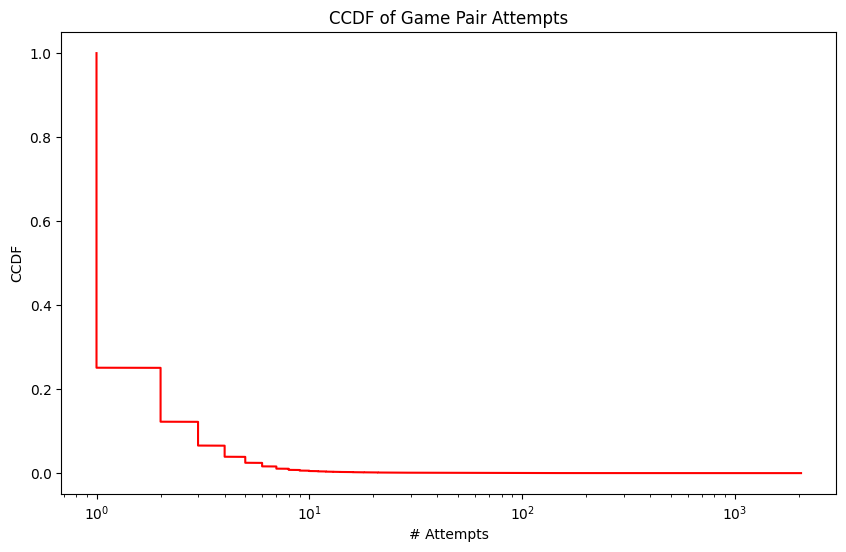

In [4]:
# CCDF of game attempts
y = np.linspace(0, 1, len(game_pair_counts['human_attempts'].sort_values()))
ccdf = 1 - y
plt.figure(figsize=(10,6))
plt.plot(game_pair_counts['human_attempts'].sort_values(), ccdf, color='red')
plt.xlabel('# Attempts')
plt.ylabel('CCDF')
plt.title('CCDF of Game Pair Attempts')
plt.xscale('log')
plt.show()

## Load Mistral Games and Conform to Human Structure

In [3]:
# open mistral data and cast as df via properly formatted nested list
with open('Mistral_7B_Games/Mistral_Games.pickle', 'rb') as file:
    mistral_nested_dict = pickle.load(file)
list_of_lists = []
for key in mistral_nested_dict:
    for i in range(len(mistral_nested_dict[key])):
        list_of_lists.append([key, mistral_nested_dict[key][f'rep{i}'], i])
mistral = pd.DataFrame(list_of_lists, columns=['game_pair', 'path_decoded', 'iteration'])

# conform to human data structure
mistral['origin'] = mistral['game_pair'].str.split("->").str[0]
mistral['goal'] = mistral['game_pair'].str.split("->").str[1]
mistral['finished'] = mistral.apply(lambda row: 1 if row['goal'] == row['path_decoded'][-1] else 0, axis=1)
mistral['path_decoded'] = mistral.apply(lambda row: [row['origin']] + row['path_decoded'], axis=1)
mistral['player_type'] = "mistral"
mistral = mistral[['player_type'] + [col for col in list(mistral.columns) if col != 'player_type']]
mistral.head()

,player_type,game_pair,path_decoded,iteration,origin,goal,finished
0,mistral,Brain->Telephone,"[Brain, Computer_science, Computer_programming...",0,Brain,Telephone,1
1,mistral,Brain->Telephone,"[Brain, Computer_science, Computer_programming...",1,Brain,Telephone,1
2,mistral,Brain->Telephone,"[Brain, Computer_science, Information, Communi...",2,Brain,Telephone,1
3,mistral,Brain->Telephone,"[Brain, Computer_science, Information, Communi...",3,Brain,Telephone,1
4,mistral,Brain->Telephone,"[Brain, Computer_science, Information, Communi...",4,Brain,Telephone,1


## Create global games dataset

In [4]:
# concat
all_game_paths = pd.concat([human, mistral])[['player_type', 'path_decoded', 'origin', 'goal', 'finished', 'game_pair', 'iteration']].reset_index(drop=True)

# unique id
all_game_paths['unique_path_id'] = all_game_paths.apply(lambda row: row['player_type'] + "_" + row['game_pair'] + "_" + str(row['iteration']), axis = 1).apply(hash).apply(abs)
all_game_paths = all_game_paths.drop(columns=['iteration'])
all_game_paths = all_game_paths[['unique_path_id'] + [col for col in list(all_game_paths.columns) if col != 'unique_path_id']]
if all_game_paths['unique_path_id'].duplicated().any() == False:
    all_game_paths.to_csv("dependencies/all_game_paths.csv")
else:
    print("global id not unique - alter creation")
all_game_paths.head()

,unique_path_id,player_type,path_decoded,origin,goal,finished,game_pair
0,2197002336743165034,human,"[10th_century, 11th_century]",10th_century,11th_century,1,10th_century->11th_century
1,5840737943989455686,human,"[10th_century, 11th_century]",10th_century,11th_century,1,10th_century->11th_century
2,5375059846858660942,human,"[10th_century, 11th_century]",10th_century,11th_century,1,10th_century->11th_century
3,5959752806179623140,human,"[10th_century, Maya_civilization, Silver, Coin...",10th_century,Banknote,1,10th_century->Banknote
4,4615764529579171299,human,"[10th_century, Germany, Country]",10th_century,Country,1,10th_century->Country


## Isolate only those games mistral played

In [5]:
mistral_game_pairs = pd.DataFrame(all_game_paths[all_game_paths['player_type'] == 'mistral']['game_pair'].value_counts().index)
relevant_paths = pd.merge(all_game_paths, mistral_game_pairs, on='game_pair')

## Mistral vs. Human: game counts and avg length "winner" (stat sig at 95% conf lev) by game pair

### game-pair level info 

In [6]:
# length at path level
relevant_paths['game_length'] = relevant_paths['path_decoded'].apply(len)
relevant_paths.loc[relevant_paths['finished'] == 0, 'game_length'] = np.nan

# for each game pair: t-tests for individual pairs
game_pair_info_dict = {}
for gp in mistral_game_pairs['game_pair']:
    tmp = relevant_paths.query(f"game_pair == '{gp}' and finished == 1")
    tmp_cnt_human = len(tmp[tmp['player_type'] == "human"])
    tmp_cnt_mistral = len(tmp[tmp['player_type'] == "mistral"])
    tmp_ttst = scipy.stats.ttest_ind(tmp[tmp['player_type'] == "human"]['game_length'], tmp[tmp['player_type'] == 'mistral']['game_length'])
    tmp_stat, tmp_pval = tmp_ttst[0], tmp_ttst[1]
    if tmp_pval < 0.05:
        tmp_sig = 1
    else:
        tmp_sig = 0
    if tmp_stat < 0 and tmp_sig == 1:
        winner = "human"
    elif tmp_stat > 0 and tmp_sig == 1:
        winner = "mistral"
    else:
        winner = "neither"
    game_pair_info_dict[gp] = [tmp_cnt_human, tmp_cnt_mistral, winner]
game_pair_info = pd.DataFrame(game_pair_info_dict).transpose().reset_index()

# modal game path length by pair and player
modal_game_length = relevant_paths[relevant_paths['finished'] == 1].groupby(['player_type', 'game_pair'])['game_length'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index()
modal_game_length = modal_game_length.pivot(index='game_pair', columns='player_type', values='game_length')
modal_game_length = modal_game_length.reset_index()
modal_game_length = modal_game_length.rename(columns={"human":"human_modal_gl", "mistral":"mistral_modal_gl"}).reset_index(drop=False)
modal_game_length = modal_game_length[['game_pair','human_modal_gl','mistral_modal_gl']]

game_pair_info = game_pair_info.rename(columns={"index": "game_pair", 0:"human_count", 1:"mistral_count", 2:"winner"})
game_pair_info = game_pair_info.merge(right=modal_game_length, on="game_pair")

c:\Users\HP\anaconda3\envs\ada\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


### tabulate

In [7]:
game_pair_info.winner.value_counts()

winner
neither    41
human      29
mistral     5
Name: count, dtype: int64

### t-tests via matching

#### Global level - match max number of paths by game (max is restricted by player with less finished paths)

In [8]:
# isolate finished paths by player and game
finished_relevant_paths = relevant_paths[relevant_paths['finished'] == 1]
human_finished_relevant_paths = finished_relevant_paths[finished_relevant_paths['player_type'] == "human"]
mistral_finished_relevant_paths = finished_relevant_paths[finished_relevant_paths['player_type'] == "mistral"]

# set smpl_n, the # to sample from each df, to minimum number of finished paths
game_pair_info['smpl_n'] = game_pair_info.apply(lambda row: min(row['human_count'], row['mistral_count']), axis=1)
sample_counts = game_pair_info[['game_pair', 'smpl_n']]

# sample the amounts in sample_counts for each game_pair in human data and mistral data, maintain matched differences
np.random.seed(5)
matched_diff_dict = {}
human_length_dict = {}
mistral_length_dict = {}
for game_pair in sample_counts['game_pair']:
    smpl_n = sample_counts[sample_counts['game_pair'] == game_pair]['smpl_n'].values[0]
    tmp_human = human_finished_relevant_paths[human_finished_relevant_paths['game_pair'] == game_pair].sample(smpl_n).reset_index()
    tmp_mistral = mistral_finished_relevant_paths[mistral_finished_relevant_paths['game_pair'] == game_pair].sample(smpl_n).reset_index()
    tmp = tmp_human.merge(right=tmp_mistral, left_index=True, right_index=True, suffixes=('_human', '_mistral'))
    tmp['diff'] = tmp['game_length_human'] - tmp['game_length_mistral']
    matched_diff_dict[game_pair] = tmp['diff'].tolist()
    human_length_dict[game_pair] = tmp['game_length_human']
    mistral_length_dict[game_pair] = tmp['game_length_mistral']

# Global t-test using matched lengths
#matched_human_lengths = [element for sublist in human_length_dict.values() for element in sublist]
#matched_mistral_lengths = [element for sublist in mistral_length_dict.values() for element in sublist]
#t_statistic, p_value = scipy.stats.ttest_ind(matched_human_lengths, matched_mistral_lengths)
t_statistic, p_value = scipy.stats.ttest_1samp([element for sublist in matched_diff_dict.values() for element in sublist], 0)
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")
np.mean([element for sublist in matched_diff_dict.values() for element in sublist])

t-statistic: -8.777983246249146
p-value: 3.8352417389369964e-18


-0.9988726042841037

#### Category level??

#### Game Pair level - visualization

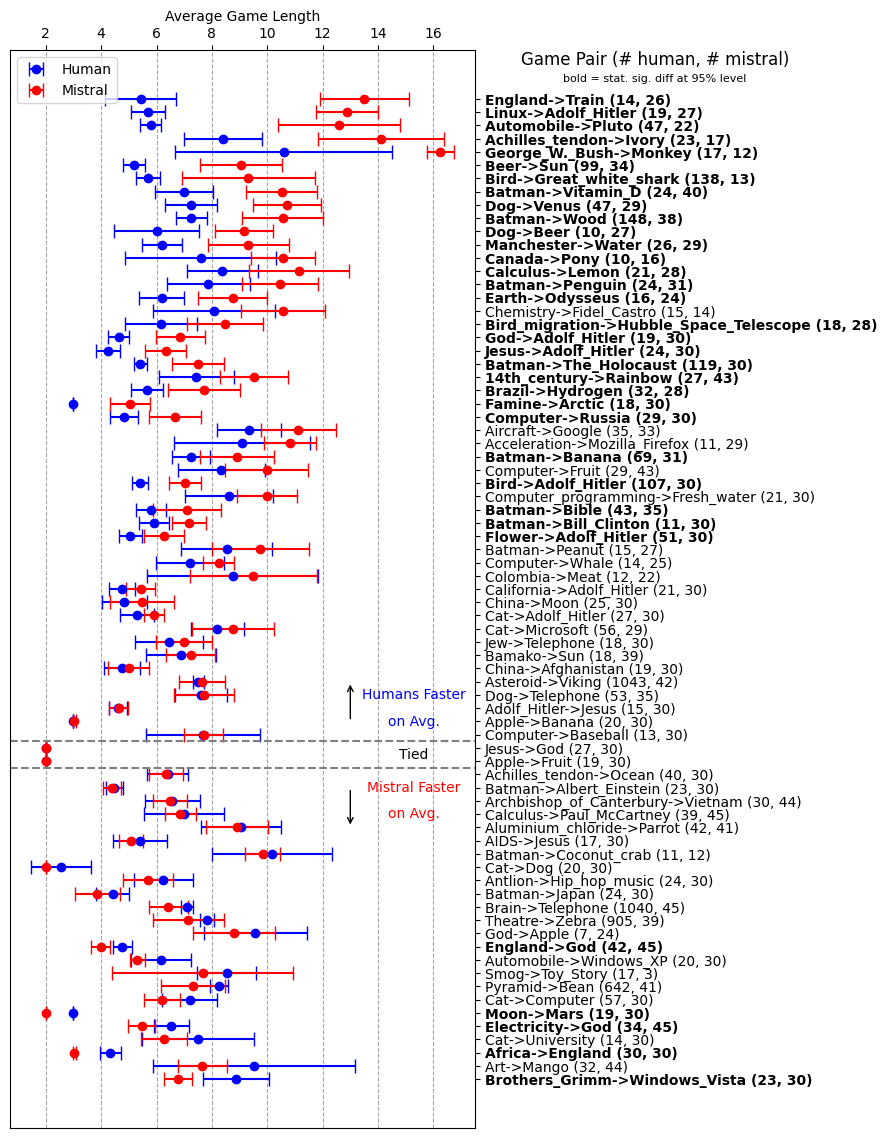

In [43]:
# for finished games: average length and games played by game path and player type
length_means = relevant_paths[relevant_paths['finished'] == 1].groupby(['player_type', 'game_pair'])['game_length'].agg(['mean','sem']).reset_index()
length_means['lower'] = length_means['mean'] - 1.96 * length_means['sem']
length_means['upper'] = length_means['mean'] + 1.96 * length_means['sem']

human_data = length_means[length_means['player_type'] == 'human']
mistral_data = length_means[length_means['player_type'] == 'mistral']

length_data = human_data.merge(mistral_data, on='game_pair', suffixes=('_human', '_mistral'))
length_data['mean_diff'] = length_data['mean_mistral'] - length_data['mean_human']
length_data = length_data.sort_values(by='mean_diff')

x_labels = [(gp + " (" + str(game_pair_info[game_pair_info['game_pair'] == gp]['human_count'].values[0]) + ", " + str(game_pair_info[game_pair_info['game_pair'] == gp]['mistral_count'].values[0]) + ")") for gp in length_data['game_pair']]
bolded = [1 if game_pair_info[game_pair_info['game_pair'] == gp]['winner'].values[0] != "neither" else 0 for gp in length_data['game_pair']]

plt.figure(figsize=(6, 14))
plt.errorbar(length_data['mean_human'], length_data['game_pair'], xerr=[length_data['mean_human'] - length_data['lower_human'], length_data['upper_human'] - length_data['mean_human']],
             fmt='o', label='Human', capsize=5, color='blue')
plt.errorbar(length_data['mean_mistral'], length_data['game_pair'], xerr=[length_data['mean_mistral'] - length_data['lower_mistral'], length_data['upper_mistral'] - length_data['mean_mistral']],
             fmt='o', label='Mistral', capsize=5, color='red')

plt.gca().yaxis.tick_right()
for i in range(len(bolded)):
    if bolded[i] == 1:
        plt.gca().get_yticklabels()[i].set_weight('bold')

plt.axhline(y=23.5, color='gray', linestyle='--', alpha=1)
plt.axhline(y=25.5, color='gray', linestyle='--')

plt.xlabel('Average Game Length')
plt.title('')
plt.legend(loc='upper left')
plt.yticks(ticks=range(len(length_data['game_pair'])), labels=x_labels)

plt.gca().xaxis.set_ticks_position('top')

plt.gca().xaxis.set_label_position('top')

plt.text(24, 77, 'Game Pair (# human, # mistral)', fontsize=12, color='black', ha='center', va='center')
plt.text(24, 75.5, 'bold = stat. sig. diff at 95% level', fontsize=8, color='black', ha='center', va='center')

plt.annotate('', xy=(13, 30), xytext=(13, 27), arrowprops=dict(arrowstyle='->'))
plt.text(15.3, 29, 'Humans Faster', fontsize=10, color='blue', ha='center', va='center')
plt.text(15.3, 27, 'on Avg.', fontsize=10, color='blue', ha='center', va='center')
plt.annotate('', xy=(13, 19), xytext=(13, 22), arrowprops=dict(arrowstyle='->'))
plt.text(15.3, 22, 'Mistral Faster', fontsize=10, color='red', ha='center', va='center')
plt.text(15.3, 20, 'on Avg.', fontsize=10, color='red', ha='center', va='center')
plt.text(15.3, 24.5, 'Tied', fontsize=10, color='black', ha='center', va='center')

plt.gca().grid(axis='x', linestyle='--', color='gray', alpha=0.7)

#plt.tight_layout()
plt.show()

#### Highest-magnitude winners

In [10]:
mag_win_game_pair = length_data[['mean_diff', 'game_pair']].merge(right=game_pair_info, on='game_pair')[['mean_diff', 'game_pair', 'winner']]
mag_win_game_pair['abs_mean_diff'] = mag_win_game_pair['mean_diff'].apply(np.abs)
mag_win_game_pair = mag_win_game_pair.sort_values(by='abs_mean_diff', ascending=False).reset_index()
mag_win_game_pair[0:20]

,index,mean_diff,game_pair,winner,abs_mean_diff
0,74,8.071429,England->Train,human,8.071429
1,73,7.204678,Linux->Adolf_Hitler,human,7.204678
2,72,6.803675,Automobile->Pluto,human,6.803675
3,71,5.726343,Achilles_tendon->Ivory,human,5.726343
4,70,5.661765,George_W._Bush->Monkey,human,5.661765
5,69,3.877005,Beer->Sun,human,3.877005
6,68,3.612040,Bird->Great_white_shark,human,3.612040
7,67,3.525000,Batman->Vitamin_D,human,3.525000
8,66,3.468819,Dog->Venus,human,3.468819
9,65,3.289118,Batman->Wood,human,3.289118


## Mistral vs. Human: evolution of % completed by game pair

In [11]:
# for cum completion calculations
total_path_counts = relevant_paths.groupby(['player_type', 'game_pair'])['unique_path_id'].agg(['count']).reset_index()

# for deciding which cum pct complete lines to show
human_finished = relevant_paths[(relevant_paths['player_type'] == 'human') & (relevant_paths['finished'] == 1)]
human_finished_pct = pd.DataFrame(human_finished.groupby('game_pair').size() / relevant_paths[relevant_paths['player_type'] == 'human'].groupby('game_pair').size()).reset_index()
human_finished_pct = human_finished_pct.rename(columns={0:"fin_pct"})
human_finished_pct = human_finished_pct[human_finished_pct['fin_pct'] < 1] # drops pairs with 100% finishes, AKA two-step games
human_finished_pct = human_finished_pct[human_finished_pct['fin_pct'] > .3] # drops pairs with just 3 human finishes
bot5_fin_human = human_finished_pct.sort_values(by="fin_pct")[0:5]
top5_fin_human = human_finished_pct.sort_values(by="fin_pct")[-5:]

In [12]:
# cumsum completed by length
lengths = relevant_paths.groupby(['player_type', 'game_pair'])['game_length'].value_counts().reset_index()
lengths = lengths.sort_values(by=['player_type','game_pair', 'game_length'])
lengths['cum_completed'] = lengths.groupby(['player_type','game_pair'])['count'].agg('cumsum')
lengths = lengths.drop(columns={"count"})
lengths = lengths.merge(right=total_path_counts, on=['player_type', 'game_pair'])
lengths['cum_completed_pct'] = lengths['cum_completed'] / lengths['count']
pct_completion = lengths.pivot(index=['game_pair', 'game_length'], columns='player_type', values='cum_completed_pct').reset_index()
pct_completion

player_type,game_pair,game_length,human,mistral
0,14th_century->Rainbow,4.0,0.140000,0.066667
1,14th_century->Rainbow,5.0,0.240000,0.200000
2,14th_century->Rainbow,6.0,0.260000,0.266667
3,14th_century->Rainbow,7.0,0.320000,0.311111
4,14th_century->Rainbow,8.0,0.380000,0.400000
...,...,...,...,...
799,Theatre->Zebra,27.0,0.507034,NaN
800,Theatre->Zebra,29.0,0.507597,NaN
801,Theatre->Zebra,32.0,0.508160,NaN
802,Theatre->Zebra,36.0,0.508723,NaN


### visualize: function

In [13]:
def cum_complete_comparison(df, subtitle):
    df = df[df['game_length'] <= 20]
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    for idx, gp in enumerate(df['game_pair'].unique()):
        pair_data = df[df['game_pair'] == gp]
        plt.plot(pair_data['game_length'], pair_data['human'], label=f'{gp}', color=colors[idx])
        plt.plot(pair_data['game_length'], pair_data['mistral'], label=f'{gp} - mistral', color=colors[idx], linestyle='--')
    plt.xlabel('Game Length')
    plt.ylabel('Cum. Proportion Completed')
    handles = [plt.Line2D([0], [0], color='w', linestyle='--')]
    handles, labels = plt.gca().get_legend_handles_labels()
    odd_handles = handles[0::2]  # Selecting odd-indexed handles starting from index 1
    odd_labels = labels[0::2]  # Selecting odd-indexed labels starting from index 1
    plt.legend(handles=odd_handles, labels=odd_labels, loc='best')
    
    plt.text(12, 0.1, 'Mistral', fontsize=10, color='black', ha='center', va='center')
    plt.text(12, 0.16, 'Human', fontsize=10, color='black', ha='center', va='center')
    plt.plot([9.6, 10.6], [0.1, 0.1], linestyle='--', marker=None, color='black')
    plt.plot([9.6, 10.6], [0.16, 0.16], linestyle='-', marker=None, color='black')

    plt.title('Completion Rates by Game Length\n' + subtitle)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

### visualize: top 5 game pairs most finished by humans

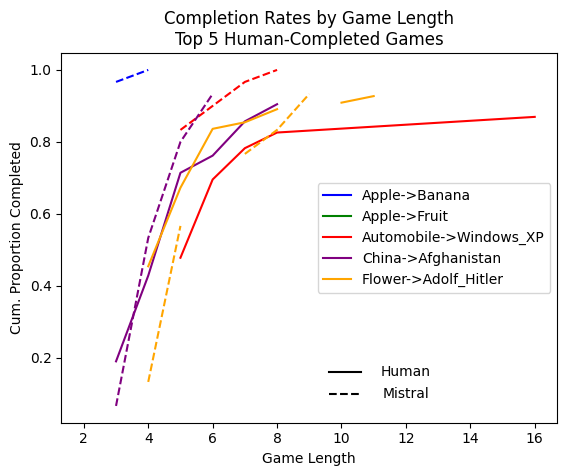

In [14]:
top5_pct_completion = pct_completion.merge(right=top5_fin_human, on="game_pair")
cum_complete_comparison(top5_pct_completion, "Top 5 Human-Completed Games")

### visualize: bottom 5 game pairs most finished by humans

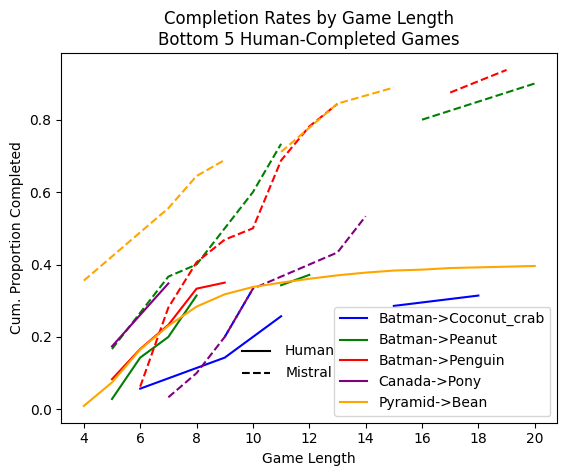

In [15]:
bot5_pct_completion = pct_completion.merge(right=bot5_fin_human, on="game_pair")
cum_complete_comparison(bot5_pct_completion, "Bottom 5 Human-Completed Games")

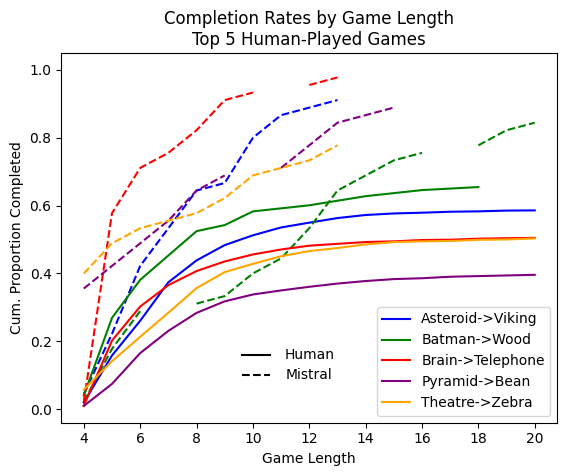

In [16]:
pop5_anywinner_pct_completion = pct_completion.merge(right=total_path_counts.query("player_type == 'human'").sort_values(by="count", ascending=False)[0:5][['game_pair']], on="game_pair")
cum_complete_comparison(pop5_anywinner_pct_completion, "Top 5 Human-Played Games")

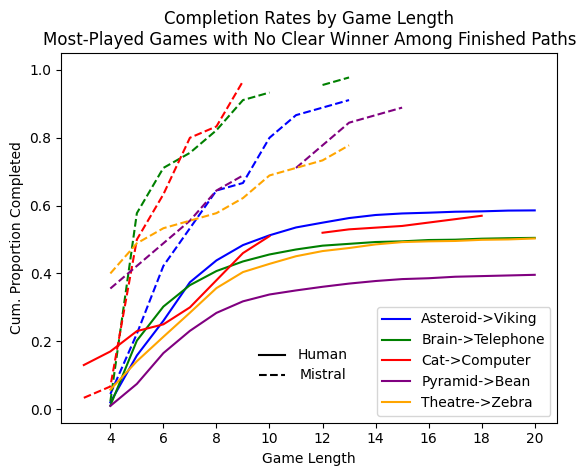

In [17]:
pop_human_games = total_path_counts.query("player_type == 'human'").sort_values(by="count", ascending=False) #[0:5][['game_pair']]
no_winner_games = game_pair_info[game_pair_info['winner'] == "neither"]
pop5_nowinner_pct_completion = pct_completion.merge(right=pop_human_games.merge(right=no_winner_games, on='game_pair')[0:5][['game_pair']], on='game_pair')
cum_complete_comparison(pop5_nowinner_pct_completion, "Most-Played Games with No Clear Winner Among Finished Paths")

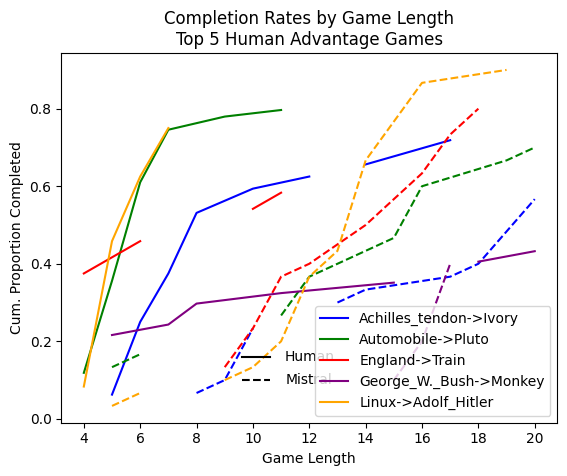

In [18]:
biggest5humangames = mag_win_game_pair[mag_win_game_pair['winner'] == "human"][0:5]['game_pair']
big5_humwin_pct_complation = pct_completion.merge(right=biggest5humangames,on='game_pair')
cum_complete_comparison(big5_humwin_pct_complation, "Top 5 Human Advantage Games")

## Mistral v Human: Degrees over time by game winner

In [19]:
# Replace backtracks with the page so degree isn't nan
relevant_paths['path_decoded_backtracks_plugged'] = relevant_paths['path_decoded']
for index, row in relevant_paths.iterrows():
    for i in range(len(row['path_decoded_backtracks_plugged'])):
        if row['path_decoded_backtracks_plugged'][i] == '<' and i >= 2:
            row['path_decoded_backtracks_plugged'][i] = row['path_decoded_backtracks_plugged'][i - 2]

In [20]:
## Average max degree along game path
outgoing_links = {}
degrees = {}

# Create dictionaries for links connections and degrees
df = pd.read_csv(os.path.join(data_dir, 'links.tsv'), sep='\t', skiprows=12, header=None)
for index, row in df.iterrows():
    start_page = urllib.parse.unquote(row[0])
    link_page = urllib.parse.unquote(row[1])
    if start_page in outgoing_links:
        outgoing_links[start_page].append(link_page)
    else:
        outgoing_links[start_page] = [link_page]
for key in outgoing_links.keys():
    degrees[key] = len(outgoing_links[key])

def get_degree_from_wikipedia_page(page_title) -> int:
    """Get degree from wikipedia page

    Args:
        page_title (str): page title

    Returns:
        int: degree of page (or NaN if not found)
    """
    return degrees.get(page_title,np.nan)

def calculate_degrees(game_path: list) -> list:
    """Get the degree of each page in a game path

    Args:
        game_path (list): game path

    Returns:
        list: list of degrees
    """
    return [get_degree_from_wikipedia_page(page) for page in game_path]

# Map game path to degree path
relevant_paths['degrees'] = [calculate_degrees(game_path) for game_path in relevant_paths['path_decoded_backtracks_plugged']]

# Calculate max degree in a given game (function handles missing values)
def find_max(lst: list) -> int:
    """Find max degree in a list

    Args:
        lst (list): list of degrees

    Returns:
        int: max degree
    """
    return max(lst) if lst else None  # Return None for empty lists

relevant_paths['max_degree'] = relevant_paths['degrees'].apply(max)

# Now average and combine with candidate set
#game_pair_cands_cats_oth = all_to_candidates(all_paths, game_pair_cands_cats_oth, 'max_degree', 'avg_max_degree', True)

### visualize: function

In [21]:
from scipy.stats import gmean

def degree_over_time_by_advantage(df, gpi, gl_values, player_type):

    df = df[df['player_type'] == player_type]
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'{player_type.capitalize()} Games: Avg. Degree Over Time')

    for idx, gl in enumerate(gl_values, start=1):
        row = (idx - 1) // 3
        col = (idx - 1) % 3

        conditions = [
            [gl, "human"],
            [gl, "mistral"]
        ]

        lines = []
        for condition in conditions:
            filtered_data = df.merge(right=gpi.query(f"winner == '{condition[1]}'"))
            filtered_data = filtered_data[(filtered_data['game_length'] == condition[0])]['degrees']
            averages = []
            for i in range(condition[0]):
                col_avg = filtered_data.apply(lambda x: x[i]).mean()
                averages.append(col_avg)
            lines.append(averages)

        x_values = range(max(map(len, lines)))
        labels = [
            f"Human Advantage", f"Mistral Advantage"
        ]

        max_length = max(len(lst) for lst in lines)
        padded_lines = [line + [np.nan] * (max_length - len(line)) for line in lines]

        line_styles = ['-', '--']  # Solid for Human, dashed for Mistral
        line_colors = ['black', 'black']  # Assigning colors

        ax = axs[row, col]

        for line, label, style, color in zip(padded_lines, labels, line_styles, line_colors):
            ax.plot(x_values, line, label=label, linestyle=style, color=color)

        ax.set_xlabel('Stage of Game (0 = Start Page)')
        ax.set_ylabel('Average Page Degree')
        ax.set_title(f"{gl}-Round Games")

        if idx == 1:  # Only add legend to the first plot
            ax.legend()
        ax.grid(True)
        ax.set_xticks(np.arange(0, max_length, step=1))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
    plt.show()

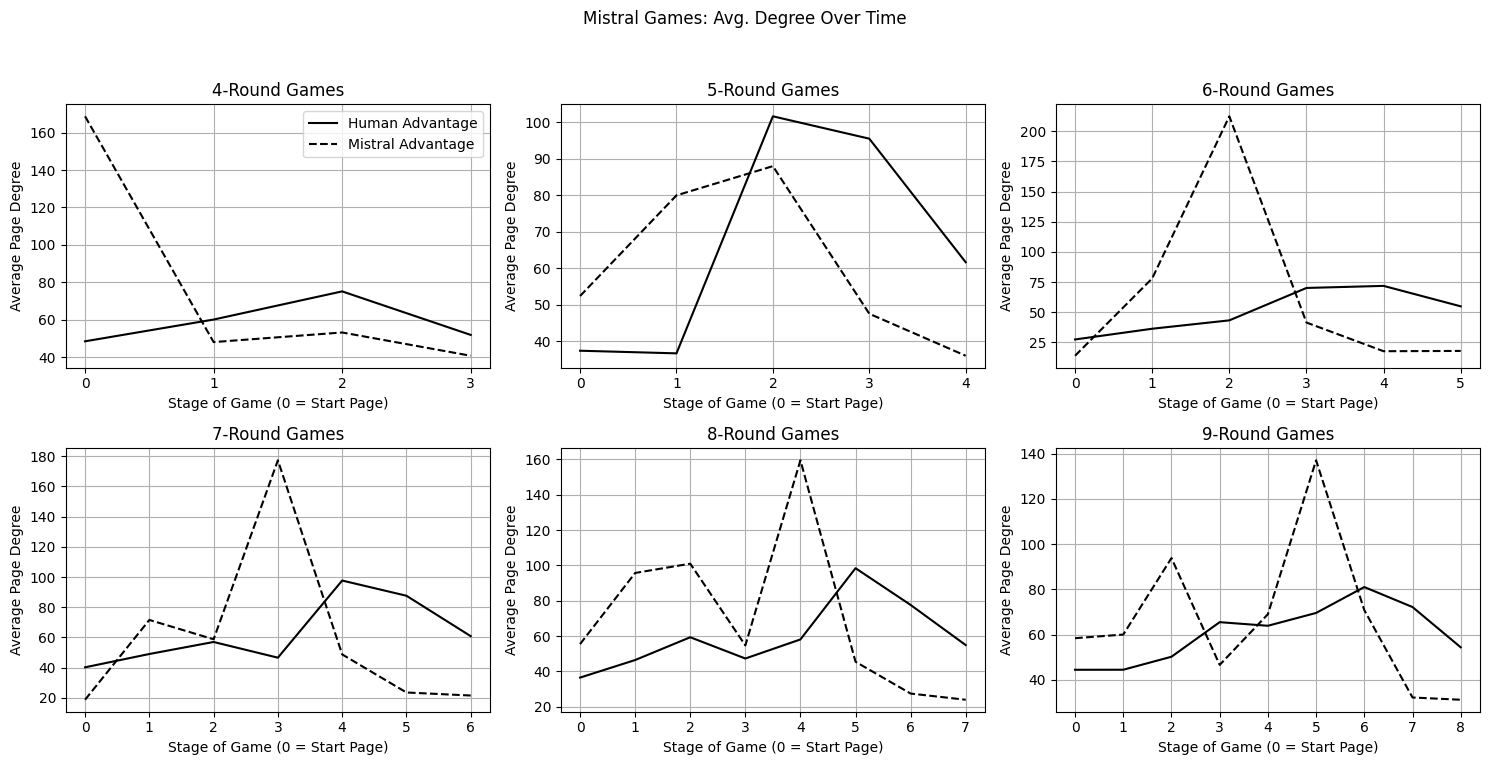

In [22]:
# Call the function with gl_values as a list of game lengths
gl_values = [4, 5, 6, 7, 8, 9]
degree_over_time_by_advantage(relevant_paths, game_pair_info, gl_values, "mistral")

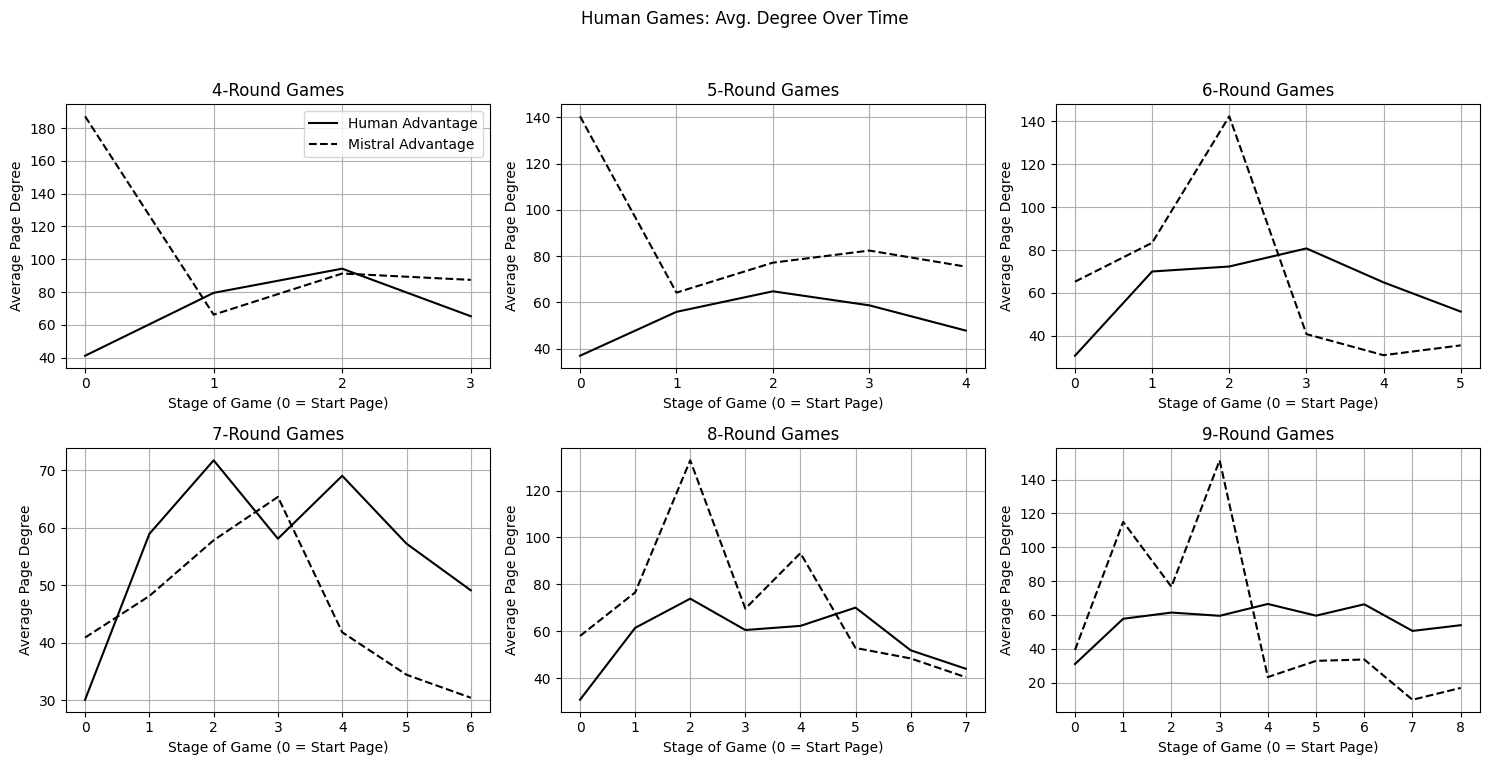

In [23]:
# Call the function with gl_values as a list of game lengths
gl_values = [4, 5, 6, 7, 8, 9]
degree_over_time_by_advantage(relevant_paths, game_pair_info, gl_values, "human")

## Mistral v Human: Embedding Similarity to Goal

In [24]:
import spacy

nlp = spacy.load('en_core_web_md')

def similarity_to_goal(embedding_path, goal):
    return [ 1 - nlp(embedded_page).similarity(nlp(goal)) for embedded_page in embedding_path]

embeddings = relevant_paths[relevant_paths['finished'] == 1][['player_type', 'game_pair', 'game_length', 'goal', 'path_decoded', 'path_decoded_backtracks_plugged']]
embeddings['simm_to_goal'] = embeddings.apply(lambda row: similarity_to_goal(row['path_decoded_backtracks_plugged'], row['goal']), axis=1)
embeddings = embeddings[['player_type', 'game_pair', 'simm_to_goal', 'game_length']]

C:\Users\HP\AppData\Local\Temp\ipykernel_15120\712311350.py:6: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return [ 1 - nlp(embedded_page).similarity(nlp(goal)) for embedded_page in embedding_path]


6173


C:\Users\HP\AppData\Local\Temp\ipykernel_15120\97467867.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embeddings['simm_to_goal'] = embeddings['simm_to_goal'].apply(reverse_list)


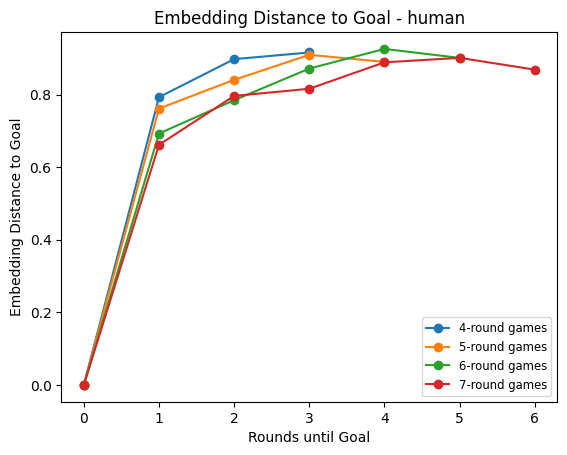

In [25]:
# create similarity path for game of length n
def reverse_list(lst):
    return lst[::-1]

def similarity_path(embeddings, game_length):
    embeddings = embeddings[embeddings['game_length'] == game_length]
    embeddings['simm_to_goal'] = embeddings['simm_to_goal'].apply(reverse_list)
    return [np.mean(simms) for simms in zip(*embeddings['simm_to_goal'])]

def visualize_similarity_paths(embeddings, player_type):
    embeddings = embeddings[embeddings['game_pair'] != "Brain->Telephone"]
    embeddings = embeddings[embeddings['game_pair'] != "Theatre->Zebra"]
    print(len(embeddings))
    embeddings = embeddings[embeddings['player_type'] == player_type]
    fig, ax = plt.subplots()
    for l in [4, 5, 6, 7]:
        simm_path_reverse = similarity_path(embeddings, l)
        ax.plot(range(len(simm_path_reverse)), simm_path_reverse, marker = 'o', label=str(l) + "-round games")
    ax.set_xlabel('Rounds until Goal')
    ax.set_ylabel('Embedding Distance to Goal')
    ax.set_title('Embedding Distance to Goal - ' + player_type)
    ax.legend(fontsize='small')
    plt.show()

visualize_similarity_paths(embeddings, "human")

6173


C:\Users\HP\AppData\Local\Temp\ipykernel_15120\97467867.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embeddings['simm_to_goal'] = embeddings['simm_to_goal'].apply(reverse_list)


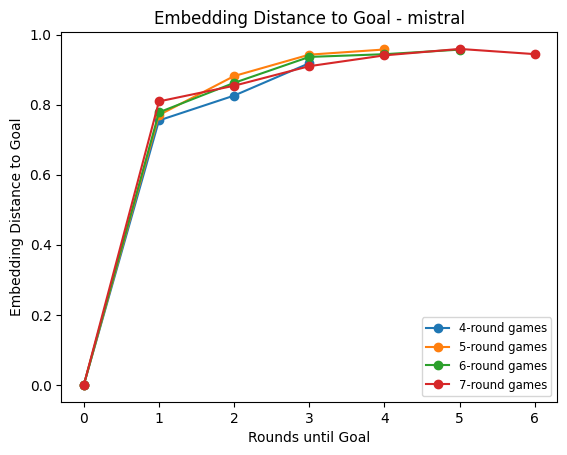

In [26]:
visualize_similarity_paths(embeddings, "mistral")

In [37]:
def sim_to_goal_over_time_by_player(df, gpi, gl_values, winner):

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'Similarity of Word Embedding to Goal over Time')

    #df = df.merge(right=gpi[gpi['winner'] == winner][['game_pair']], on = 'game_pair')
    df = df[df['game_pair'] == "Brain->Telephone"]
    for idx, gl in enumerate(gl_values, start=1):
        row = (idx - 1) // 3
        col = (idx - 1) % 3

        lines = []
        for pt in ["human","mistral"]:
            df_tmp = df[df['player_type'] == pt]
            simm_path_reverse = similarity_path(df_tmp, gl)
            lines.append(simm_path_reverse)

        x_values = range(max(map(len, lines)))
        labels = [
            f"Human", f"Mistral"
        ]

        max_length = max(len(lst) for lst in lines)
        padded_lines = [line + [np.nan] * (max_length - len(line)) for line in lines]

        line_styles = ['-', '--']  # Solid for Human, dashed for Mistral
        line_colors = ['black', 'black']  # Assigning colors

        ax = axs[row, col]

        for line, label, style, color in zip(padded_lines, labels, line_styles, line_colors):
            ax.plot(x_values, line, label=label, linestyle=style, color=color)

        ax.set_xlabel('Rounds to Goal')
        ax.set_ylabel('Cos. Similarity of Page to Goal (Word Embeddings)')
        ax.set_title(f"{gl}-Round Games")

        if idx == 1:  # Only add legend to the first plot
            ax.legend()
        ax.grid(True)
        ax.set_xticks(np.arange(0, max_length, step=1))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
    plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_15120\97467867.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embeddings['simm_to_goal'] = embeddings['simm_to_goal'].apply(reverse_list)


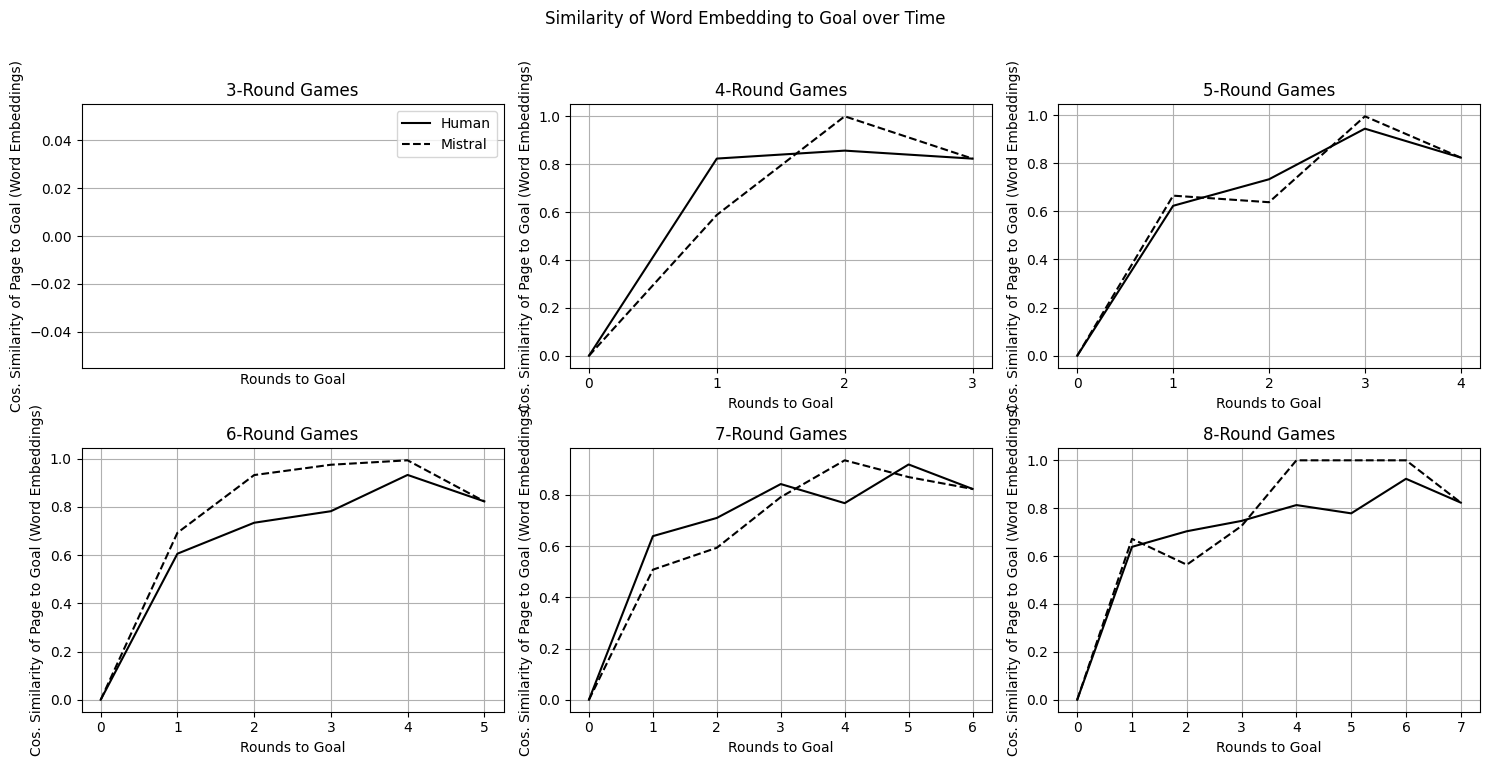

In [38]:
gl_values = [3, 4, 5, 6, 7, 8]
sim_to_goal_over_time_by_player(embeddings, game_pair_info, gl_values, "neither")

-------------------------------------------------------------------------------------------------------------------------

# MILESTONE 2 BELOW

-------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------

<h1 style="text-align: center;">Man vs AI: A comparison of Human and LLM Wikispeedia Strategy</h1>

<h3 style="text-align: center;">Klech</h3>

<img src="./dependencies/HUMANvsAI.webp"  style="width:20%; display: block; margin: 0 auto;">


**Snippet of Abstract:** Can an LLM emulate through behavior the same thinking underpinning human semantic maps? To answer this question, we will enlist ChatGPT as a participant in Wikispeedia and evaluate its performance across a subset of popular but meaningfully diverse origin-goal page pairs previously played by humans.

--------------------------------------------------------------

We have chosen to manually prompt ChatGPT online to develop our LLM Wikispeedia game paths. We therefore use this workbook to walk through our decisions regarding which origin-goal Wikipedia page pairs (henceforth 'game pairs') to have ChatGPT 'play', which prompt to use to make ChatGPT play Wikispeedia, and the shape our intended analysis will take once data becomes available.

#### Table of Contents:

0. [Quick Setup](#quick-setup)
1. [Wikispeedia Page-Pair Selection](#pair-selection)
2. [LLM and Prompt Selection](#llm-prompts)
3. [Methods](#methods)


## 0. Quick Setup <a class="anchor" id="quick-setup"></a>

Since the code deals with a share of LLMs from Hugging Face, we recommend running the code on Google Colab if you don't have a GPU on your local machine.

Note that in sections [0.1 Install and import the necessary Python libraries](#0.1-Install-and-import-the-necessary-Python-libraries) and [0.2 Access the data](#0.2.-Access-the-data) you will have to run different code based on whether you are running the tutorial on Colab or on Jupyter Notebook. An `if statement` will take care of this. You only need to select `'colab'` or `'jupyter_notebook'` for the `platform` variable below.

In [63]:
platform = 'jupyter_notebook' #@param ['colab', 'jupyter_notebook'] {allow-input: true}

### 0.1 Install and import the necessary Python libraries

In [64]:
# install libraries
if platform == 'colab':
    !pip install transformers accelerate einops

else:
    !pip install . # this will install all the requirements specified in the setup.py file. Note that: you might want to crate a new venv before running this command.

Processing /home/drudao/Desktop/EPFL/Year_I/AppliedDataAnalysis/Projects/ada-2023-project-klech
  Preparing metadata (setup.py) ... done
  Created wheel for ada-2023-project-klech: filename=ada_2023_project_klech-1.0.0-py3-none-any.whl size=5083 sha256=6fe47bdd061ea0c1338e0aa0f5849b137dd68b00e6cc677d8aeefa4a3d60a1e1
  Stored in directory: /home/drudao/.cache/pip/wheels/0c/5d/56/9f48ec73401ad54abbac23b469848897fe830fa83728ed309a
Successfully built ada-2023-project-klech
  Attempting uninstall: ada-2023-project-klech
    Found existing installation: ada-2023-project-klech 1.0.0
    Uninstalling ada-2023-project-klech-1.0.0:
      Successfully uninstalled ada-2023-project-klech-1.0.0


In [65]:
# import libraries
import torch
import os
import numpy as np
import urllib.parse
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import Counter
from urllib.parse import unquote
from matplotlib.lines import Line2D
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BartTokenizer, BartModel, pipeline 

### 0.2 Access the data

In [67]:
if platform == 'colab':
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    data_dir = '/content/drive/MyDrive/wikispeedia_data/wikispeedia_paths-and-graph/' #@param {type:"string"}
    dependencies_dir = '/content/drive/MyDrive/wikispeedia_data/' #@param {type:"string"}
else:
    data_dir = os.path.join(os.getcwd(), 'dependencies', 'wikispeedia_paths-and-graph')
    dependencies_dir = os.path.join(os.getcwd(), 'dependencies')

## 1. Wikispeedia Page-Pair Selection <a class="anchor" id="pair-selection"></a>

### 1.1: Game Pairs (paths_finished.tsv and paths_unfinished.tsv)

We cannot simulate every Wikispeedia game. We therefore focus on more popular game pairs.

First, we load in our data and compute its scale.

In [68]:
# decode url text inside page names
def decode_list(url_encoded_list):
    """Decodes url_encoded path.
    
    Args:
        url_encoded_list (list): list of url_encoded page names
    
    Returns:
        list: list of decoded page names
    """
    return [urllib.parse.unquote(element).replace(',', '') for element in url_encoded_list]

# pull in finished games and prepare for append
paths_finished = pd.read_csv(os.path.join(data_dir, 'paths_finished.tsv'), sep='\t', skiprows = 16, header = None, names = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
paths_finished['path_decoded'] = paths_finished['path'].str.split(';').apply(decode_list)
paths_finished['origin'] = paths_finished['path_decoded'].str[0]
paths_finished['goal'] = paths_finished['path_decoded'].str[-1]
paths_finished['finished'] = 1

# pull in unfinished games and prepare for append
paths_unfinished = pd.read_csv(os.path.join(data_dir, 'paths_unfinished.tsv'), sep='\t', skiprows=17, header = None, names = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
paths_unfinished['path_decoded'] = paths_unfinished['path'].str.split(';').apply(decode_list)
paths_unfinished['origin'] = paths_unfinished['path_decoded'].str[0]
paths_unfinished = paths_unfinished.rename(columns={'target': 'goal'})
paths_unfinished['finished'] = 0

# append
all_paths = pd.concat([paths_finished, paths_unfinished])
all_paths['game_pair'] = all_paths['origin'] + "->" + all_paths['goal']
print("There are " + str(len(paths_finished)) + " finished games and " + str(len(paths_unfinished)) + " unfinished games, amounting to " + str(len(all_paths)) + " game attempts total.")
print("{:.2f}%".format(all_paths[all_paths['finished'] == 0]['goal'].isnull().sum()) + " of unfinished paths are missing data on the game goal.\n")
game_pair_counts = all_paths['game_pair'].value_counts().rename_axis('game_pair').reset_index(name='count')
if platform == 'colab':
  game_pair_counts = game_pair_counts.rename(columns={'game_pair': 'human_attempts', 'index':'game_pair'})
else:
   game_pair_counts = game_pair_counts.rename(columns={'count': 'human_attempts'})


There are 51318 finished games and 24875 unfinished games, amounting to 76193 game attempts total.
0.00% of unfinished paths are missing data on the game goal.



There are plenty of game pairs to choose from across 76,000 game attempts. However, not all pairs would be equally useful for this project. Take a look at the CCDF of game pair popularity (according to sum of completed and uncompleted human attempts) below.

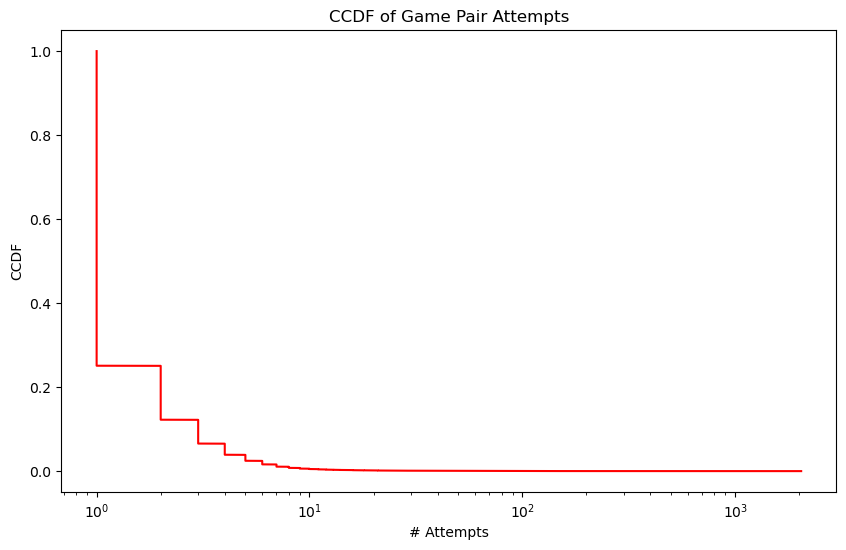

In [69]:
# CCDF of game attempts
y = np.linspace(0, 1, len(game_pair_counts['human_attempts'].sort_values()))
ccdf = 1 - y
plt.figure(figsize=(10,6))
plt.plot(game_pair_counts['human_attempts'].sort_values(), ccdf, color='red')
plt.xlabel('# Attempts')
plt.ylabel('CCDF')
plt.title('CCDF of Game Pair Attempts')
plt.xscale('log')
plt.show()

A stunning majority of pairs have been attempted less than 10 times. Clearly, when selecting 10 pairs for our LLM to play, it would not do to choose a random subset, as we need to choose pairs with multiple human attempts in order to make meaningful comparisons to LLM attempts.

Let us sample a selection of pairs with at least 25 game attempts:

In [70]:
game_pair_cands = game_pair_counts.query('human_attempts >= 25')
display(game_pair_cands.sample(n=10, random_state=55))
print(str(len(game_pair_cands[game_pair_cands['game_pair'].str.contains('Batman')])) + " of the " + str(len(game_pair_cands)) + " games with 25 or more attempts include 'Batman'.")

,game_pair,human_attempts
3,Pyramid->Bean,1586
4,Batman->Wood,223
22,Flower->Adolf_Hitler,55
32,China->Moon,36
52,Bird_migration->Hubble_Space_Telescope,25
5,Bird->Great_white_shark,168
15,Computer->Fruit,65
6,Batman->The_Holocaust,149
28,Archbishop_of_Canterbury->Vietnam,42
38,Manchester->Water,33


10 of the 54 games with 25 or more attempts include 'Batman'.


We can readily see several concepts appearing in multiple games - another issue with random sampling if our goal is to expose the LLM to conceptual variety. We will retain the set of game pairs with more than 25 attempts as our candidate pool but turn now to a means of enforcing conceptual variety.

### 1.2: Category (categories.tsv)

The category data maps Wikipedia pages to conceptual groupings. To ensure the LLM is exposed to a variety of semantic concepts, we can not only ensure no one page appears more than once in our subset of game pairs, but we can also ensure no one category appears more than 1-2 times in our selected subset of game pairs.

Below, we display the distribution of categories across all Wikipedia pages in the global Wikispeedia dataset (blue) and across those Wikipedia pages appearing inside those game pairs attempted 25 or more times (orange).

/tmp/ipykernel_1474471/863954107.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_pair_cands.loc[:, 'origin'] = game_pair_cands['game_pair'].str.split("->").str[0]
/tmp/ipykernel_1474471/863954107.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_pair_cands.loc[:, 'goal'] = game_pair_cands['game_pair'].str.split("->").str[-1]


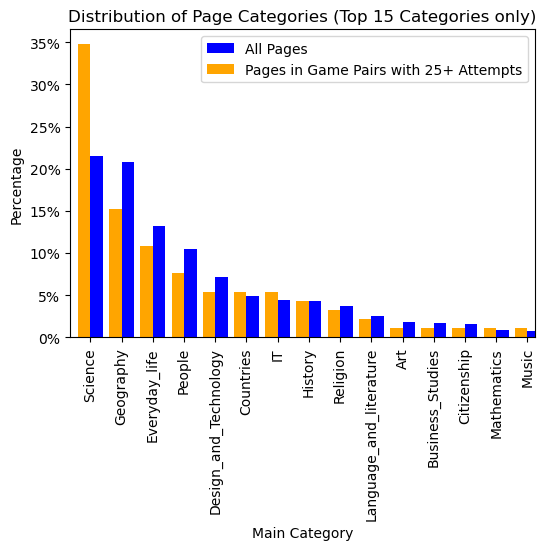

In [71]:
# Pull in categories for all pages appearing inside game pairs
categories_all = pd.read_csv(os.path.join(data_dir, 'categories.tsv'), sep='\t', skiprows=13, header = None, names = ['article','category'])
categories_all[['article', 'category']] = categories_all[['article', 'category']].apply(lambda x: x.map(unquote))
categories_all['main_category'] = categories_all['category'].apply(lambda x: x.split('.')[1] if len(x.split('.')) > 1 else x)
top_categories_all = categories_all['main_category'].value_counts().head(15)

# Isolate categories for those pages appearing inside pairs with at least 20 game attempts
game_pair_cands.loc[:, 'origin'] = game_pair_cands['game_pair'].str.split("->").str[0]
game_pair_cands.loc[:, 'goal'] = game_pair_cands['game_pair'].str.split("->").str[-1]
categories_cands = pd.DataFrame({'article': list(set(pd.concat([game_pair_cands['origin'], game_pair_cands['goal']])))}).merge(right=categories_all, how='left')
top_categories_cands = categories_cands['main_category'].value_counts().head(15)

# display global and subset distribution
percentages_all = (top_categories_all / top_categories_all.sum())
percentages_cands = (top_categories_cands / top_categories_cands.sum())
plt.figure(figsize=(6, 4))
ax = percentages_all.plot(kind='bar', color='blue', position=0, width=0.4)
percentages_cands.plot(kind='bar', color='orange', position=1, width=0.4, ax=ax)

plt.title('Distribution of Page Categories (Top 15 Categories only)')
plt.xlabel('Main Category')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.legend(['All Pages', 'Pages in Game Pairs with 25+ Attempts'])

ax.yaxis.set_major_formatter('{:.0%}'.format)

plt.show()

The distribution of categories for our candidate set is, as with the global set of pages, skewed. However, there still exists enough representation to ensure diversity of category (and therefore concepts pursued by the LLM) among game pairs.

We attach category information **for goals** to our candidate set and proceed to inspect other variables relevant to our analysis. Candidate game pairs with a goal with more than one primary category are removed to ensure maximum separability of targeted concepts.

In [72]:
game_pair_cands_cats = game_pair_cands.merge(right = categories_cands, left_on='goal', right_on='article')[['game_pair', 'human_attempts', 'origin', 'goal', 'main_category']].copy()
game_pair_cands_cats = game_pair_cands_cats[~game_pair_cands_cats['game_pair'].duplicated(keep=False)].reset_index(drop=True).copy()
game_pair_cands_cats = game_pair_cands_cats.rename(columns={'main_category':'goal_category'})
display(game_pair_cands_cats.head())
print(str(len(game_pair_cands) - len(game_pair_cands_cats)) + " candidate game pairs dropped. " + str(len(game_pair_cands_cats)) + " remain.")

,game_pair,human_attempts,origin,goal,goal_category
0,Brain->Telephone,2044,Brain,Telephone,Design_and_Technology
1,Dog->Telephone,89,Dog,Telephone,Design_and_Technology
2,Jew->Telephone,30,Jew,Telephone,Design_and_Technology
3,Theatre->Zebra,1777,Theatre,Zebra,Science
4,Bird->Great_white_shark,168,Bird,Great_white_shark,Science


13 candidate game pairs dropped. 41 remain.


### 1.3: Average rounds-to-completion, maximum degree along game path, % of attempts containing a backtrack (paths_finished.tsv, paths_unfinished.tsv, links.tsv)

Given the nature of our intended analysis (see Methods section below), it would be helpful to select game pairs for which there is variation in difficulty, connectedness of hubs employed by humans, and propensity of humans to reverse previous decisions. These can be targeted with statistics compiled at the game pair level: average rounds-to-game-completion proxies for difficulty, average maximum outgoing Wikipedia links from a single page on a game path proxies for hub connectedness, and percentage of games in which backtracks occur captures the last variable.

We first calculate each variable for our candidate game pairs.

In [73]:
def all_to_candidates(
    all_paths: pd.DataFrame,
    candidates: pd.DataFrame,
    new_var_pre_agg: str,
    new_var_post_agg: str,
    finished_only: bool
) -> pd.DataFrame:    
    """For mapping all_path data to candidate set
    
    Args:
        all_paths (pd.DataFrame): all paths data
        candidates (pd.DataFrame): candidate set
        new_var_pre_agg (str): variable to aggregate
        new_var_post_agg (str): name of new variable
        finished_only (bool): whether to aggregate only finished games
    Returns:
        pd.DataFrame: candidates with new variable
    """
    if finished_only == True:
        all_pairs_avg = all_paths[all_paths['finished'] == 1].groupby('game_pair')[new_var_pre_agg].agg('mean').reset_index().copy()
    else:
        all_pairs_avg = all_paths.groupby('game_pair')[new_var_pre_agg].agg('mean').reset_index().copy()
    all_pairs_avg = all_pairs_avg.rename(columns={new_var_pre_agg:new_var_post_agg})
    return candidates.merge(right=all_pairs_avg, on='game_pair').copy()

In [74]:
## Average rounds-to-completion
all_paths['game_length'] = all_paths['path_decoded'].apply(len)
all_paths.loc[all_paths['finished'] == 0, 'game_length'] = np.nan
game_pair_cands_cats_oth = all_to_candidates(all_paths, game_pair_cands_cats, 'game_length', 'avg_game_length', True)

In [75]:
## Average max degree along game path
outgoing_links = {}
degrees = {}

# Create dictionaries for links connections and degrees
df = pd.read_csv(os.path.join(data_dir, 'links.tsv'), sep='\t', skiprows=12, header=None)
for index, row in df.iterrows():
    start_page = urllib.parse.unquote(row[0])
    link_page = urllib.parse.unquote(row[1])
    if start_page in outgoing_links:
        outgoing_links[start_page].append(link_page)
    else:
        outgoing_links[start_page] = [link_page]
for key in outgoing_links.keys():
    degrees[key] = len(outgoing_links[key])

def get_degree_from_wikipedia_page(page_title) -> int:
    """Get degree from wikipedia page

    Args:
        page_title (str): page title

    Returns:
        int: degree of page (or NaN if not found)
    """
    return degrees.get(page_title,np.nan)

def calculate_degrees(game_path: list) -> list:
    """Get the degree of each page in a game path

    Args:
        game_path (list): game path

    Returns:
        list: list of degrees
    """
    return [get_degree_from_wikipedia_page(page) for page in game_path]

# Map game path to degree path
all_paths['degrees'] = [calculate_degrees(game_path) for game_path in all_paths['path_decoded']]

# Calculate max degree in a given game (function handles missing values)
def find_max(lst: list) -> int:
    """Find max degree in a list

    Args:
        lst (list): list of degrees

    Returns:
        int: max degree
    """
    return max(lst) if lst else None  # Return None for empty lists

all_paths['max_degree'] = all_paths['degrees'].apply(max)

# Now average and combine with candidate set
game_pair_cands_cats_oth = all_to_candidates(all_paths, game_pair_cands_cats_oth, 'max_degree', 'avg_max_degree', True)

In [76]:
## % of games with backtrack
all_paths['backtrack_occurred'] = all_paths['path_decoded'].apply(lambda x: any('<' in page for page in x))
game_pair_cands_cats_oth = all_to_candidates(all_paths, game_pair_cands_cats_oth, 'backtrack_occurred', 'share_backtrack_occurred', finished_only = False)

In [77]:
# updated candidate df
game_pair_cands_cats_oth.head()

,game_pair,human_attempts,origin,goal,goal_category,avg_game_length,avg_max_degree,share_backtrack_occurred
0,Brain->Telephone,2044,Brain,Telephone,Design_and_Technology,7.100000,95.138462,0.177104
1,Dog->Telephone,89,Dog,Telephone,Design_and_Technology,7.622642,163.622642,0.224719
2,Jew->Telephone,30,Jew,Telephone,Design_and_Technology,6.444444,244.277778,0.133333
3,Theatre->Zebra,1777,Theatre,Zebra,Science,7.836464,166.501657,0.195273
4,Bird->Great_white_shark,168,Bird,Great_white_shark,Science,5.695652,57.391304,0.059524


We are now equipped with all we need to select our 10 game pairs. We select our game pairs in the next section and visualize their location over distributions for our selection variables.

Note that we did not include share of games abandoned in our set of relevant variables because we already had a proxy for difficulty and a metric quantifying backtracks; further selection variables would only complicate extraction of our subset.

### 1.4: Selecting the 10 game pairs the LLM will play

Our subset of 10 game pairs will fulfill the following requirements:
- No one article appears as an origin or goal more than once
- No goal article category appears more than twice
- The sum of the standard errors of standardized avg_game_length, avg_max_degree, and share_backtrack_occurred in the subset is the maximum across all subsets matching the above conditions

We achieve these conditions with the loop below.

In [78]:
# Standardize quantitative variables
quant_vars = ['avg_game_length', 'avg_max_degree', 'share_backtrack_occurred']
quant_vars_new = ['avg_game_length_stdiz', 'avg_max_degree_stdiz', 'share_backtrack_occurred_stdiz']
game_pair_cands_cats_oth[quant_vars_new] = (game_pair_cands_cats_oth[quant_vars] - game_pair_cands_cats_oth[quant_vars].mean()) / game_pair_cands_cats_oth[quant_vars].std()

# Select subset!
def find_10_pairs_for_llm() -> pd.DataFrame:
    """Find 10 pairs for LLM

    Returns:
        pd.DataFrame: 10 pairs for LLM
    """    
    seed = 5
    sample = "none"
    running_se_sum = 0
    failed_to_update = 0
    while failed_to_update < 2000:
        seed += 1
        tmp_sample = game_pair_cands_cats_oth.sample(n=10, random_state=seed)
        # confirm pages only appear once as origin or goal
        if len(set(pd.concat([tmp_sample['origin'], tmp_sample['goal']]))) != 20:
            pass
        # confirm categories only appear once or twice among goal
        elif tmp_sample['goal_category'].value_counts().max() > 2:
            pass
        # allow final set to update if quantitative var standard error sum is higher
        else:
            sample_se_sum = tmp_sample['avg_game_length_stdiz'].var() + tmp_sample['avg_max_degree_stdiz'].var() + tmp_sample['share_backtrack_occurred_stdiz'].var()
            if sample_se_sum > running_se_sum:
                sample = tmp_sample
                running_se_sum = sample_se_sum
            else:
                failed_to_update += 1
    return sample
final_pairs = find_10_pairs_for_llm()

final_pairs.to_csv("dependencies/game_pairs_for_LLM.csv")
display(final_pairs['game_pair'])

25     14th_century->Rainbow
7         Bird->Adolf_Hitler
30      Batman->Coconut_crab
29           Africa->England
27    George_W._Bush->Monkey
37    Antlion->Hip_hop_music
14          Aircraft->Google
22                Jesus->God
16           Computer->Fruit
2             Jew->Telephone
Name: game_pair, dtype: object

We can confirm our unique concept and mostly unique category conditions with visual inspection:

In [79]:
display(final_pairs)

,game_pair,human_attempts,origin,goal,goal_category,avg_game_length,avg_max_degree,share_backtrack_occurred,avg_game_length_stdiz,avg_max_degree_stdiz,share_backtrack_occurred_stdiz
25,14th_century->Rainbow,50,14th_century,Rainbow,Geography,7.444444,80.592593,0.200000,0.439756,-1.182207,0.494393
7,Bird->Adolf_Hitler,129,Bird,Adolf_Hitler,People,5.401869,153.214953,0.100775,-0.621009,0.296003,-0.595969
30,Batman->Coconut_crab,35,Batman,Coconut_crab,Science,10.181818,76.181818,0.428571,1.861348,-1.271987,3.006120
29,Africa->England,35,Africa,England,Geography,4.333333,212.000000,0.000000,-1.175928,1.492558,-1.703368
27,George_W._Bush->Monkey,37,George_W._Bush,Monkey,Science,10.588235,135.235294,0.405405,2.072411,-0.069968,2.751553
37,Antlion->Hip_hop_music,29,Antlion,Hip_hop_music,Music,6.250000,213.250000,0.206897,-0.180551,1.518001,0.570178
14,Aircraft->Google,78,Aircraft,Google,IT,9.342857,191.742857,0.243590,1.425653,1.080229,0.973392
22,Jesus->God,27,Jesus,God,Religion,2.000000,59.000000,0.000000,-2.387691,-1.621719,-1.703368
16,Computer->Fruit,65,Computer,Fruit,Everyday_life,8.344828,114.034483,0.200000,0.907349,-0.501506,0.494393
2,Jew->Telephone,30,Jew,Telephone,Design_and_Technology,6.444444,244.277778,0.133333,-0.079571,2.149564,-0.238194


Furthermore, we can confirm our pairs exhibit sufficient variance with respect to our quantitative selection variables by displaying them on a global distribution:

/home/drudao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/drudao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drudao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/drudao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

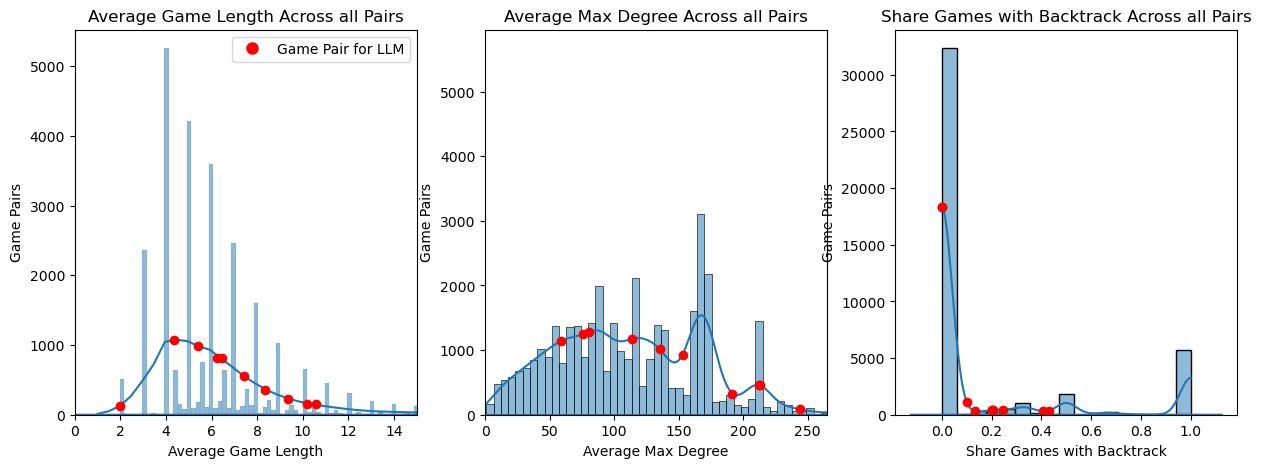

In [80]:
all_pairs_qvars =all_paths.groupby('game_pair')[['max_degree', 'backtrack_occurred', 'game_length']].agg('mean').reset_index()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
def histogram_w_final_selection(qvar: str, agg_adder: str, x_label: str, ax: np.ndarray) -> None:
    """Histogram with final selection

    Args:
        qvar (str): quantitative variable
        agg_adder (str): aggregation adder
        x_label (tsr): x label
        ax (np.ndarray): axis
    """
    sns.histplot(data=all_pairs_qvars, x=qvar, kde=True, ax=ax)
    kde = sns.kdeplot(data=all_pairs_qvars[qvar], legend=False, ax=ax)
    kde_data = kde.get_lines()[0].get_data()

    final_pairs_location = final_pairs[agg_adder + qvar]
    for x in final_pairs_location:
        closest_index = np.argmin(np.abs(kde_data[0] - x))
        y = kde_data[1][closest_index]
        ax.plot(x, y, 'ro')

    ax.set_xlabel(x_label)
    ax.set_ylabel('Game Pairs')
    ax.set_title(x_label + ' Across all Pairs')
    if qvar == 'game_length':
        ax.set_xlim(0,15)
        legend_elements = [Line2D([0], [0], marker='o', color='red', label='Game Pair for LLM', markersize=8, linestyle='None')]
        ax.legend(handles=legend_elements)
    if qvar == 'max_degree':
        ax.set_xlim(0,265)

histogram_w_final_selection('game_length', 'avg_', 'Average Game Length', axs[0])
histogram_w_final_selection('max_degree', 'avg_', 'Average Max Degree', axs[1])
histogram_w_final_selection('backtrack_occurred', 'share_', 'Share Games with Backtrack', axs[2])

With a set of 10 game pairs played 25 times or more that vary in target category while also exhibiting a varied and representative distribution of average game length, average maximum degree on game path, and share of games with backtracking, we know now the Wikispeedia games we can ask an LLM to play that will yield data relevant to our research questions.

However, we cannot begin developing external data without settling on an LLM and prompt architecture. This is subject of the next section.

## 2. LLM and Prompt Selection <a class="anchor" id="llm-prompts"></a>

**Motivation**

In order to obtain LLMs data relevant to our research questions, we must select an LLM and prompt architecture that will allow us to emulate the Wikispeedia game experience. The models we are considering, however, are all (relatively) small models due to the computational constraints of our local machines. This makes the task of playing the game very difficult for them, and indeed , results are very disappointing, and led us into manually playing the Wikispeedia game through prompt and dcollection of resposes on the online version of ChatGPT.

To make sure the limitations were actually coming from the model side and not from poor prompts, we tried many different models on many different prompts. Below the results of our experiments.

**Test setup**

In order to test the validity of the chosen LM, we asked it to navigate Africa -> England (as an example of an hard task with a long list to choose from), or Batman -> Coconut_crab (much shorter list to choose from). Both the paths were selected from the 10 game pairs. For each prompt we tested the ability of the model to: a) choose an answer in the provided set of available links; b) choose the goal word (Coconut_crab) as soon as it appears in set of available links.

Some models were more promising than others, but at the end of the day the performance was not good enough to be used for our analysis. Hence, we decided to manually play the game through prompt and dcollection of resposes on the online version of ChatGPT.

**Notes on the models**

This part of the notebook was run on Google Colab using a T4 GPU. Uploading the notebook to github resulted in the following error for all model loading graphics: 

*Could not render content for 'application/vnd.jupyter.widget-view+json'* 

The LLM answers to our prompts are still visible. 


#### 2.0 Defining the initial set up for our test

In [69]:
# Define a link extractor funtion. This will be useful because we will need to extract links based on the selected page at every step.

links = {}

df = pd.read_csv(os.path.join(data_dir, 'links.tsv'), sep='\t', skiprows=12, header=None)

# Iterate over the dataframe rows
for index, row in df.iterrows():
    start_page = urllib.parse.unquote(row[0])
    link_page = urllib.parse.unquote(row[1])
    if start_page in links:
        links[start_page].append(link_page)
    else:
        links[start_page] = [link_page]

# Function for pulling links
def get_links_from_wikipedia_page(page_title: str) -> list:
    """Get links from wikipedia page

    Args:
        page_title (str): page title

    Returns:
        list: list of links from page
    """
    return links.get(page_title, [])

# Example: first 5 links from Batman page
print(get_links_from_wikipedia_page('Batman')[:5])

['Chemistry', 'Crime', 'Earthquake', 'Scotland', 'Spring_Heeled_Jack']


In [72]:
# List of prompts we tried. Ordered from simple to complex.

def get_inputs(
    current_page: str,
    target: str,
    complexity: int,
    type_of_model: str
    ) -> str | tuple[str, list]:
    """
    Takes the current page, the target page, the complexity of the prompt (1,2,3,4), and the type of model ('text-gen', 'qa').
    Returns the prompt, or the context and the question.
    
    Args:
        current_page (str): current page
        target (str): target page
        complexity (int): complexity of prompt
        type_of_model (str): type of model ('text-gen', 'qa')
    Returns:
        str | tuple[str, list]: prompt, or context and question
    """

    CANDIDATES = ', '.join(get_links_from_wikipedia_page(current_page))
    TARGET = target

    if type_of_model == 'text-gen':
        prompts = {}
        prompts['prompt1'] = f"The one concept that is semantically closest to <{TARGET}> from the following set : {CANDIDATES} is:"
        prompts['prompt2'] = f"Choosing only from the set {CANDIDATES}, the one concept that is semantically closest to <{TARGET}> is: "
        # trying some chain-of-thought prompts, which are some times more effective:
        prompts['prompt3'] = f"From the set ['Car', 'Tree', 'University'], Henry_Ford is semantically closest to 'Car' because he was the founder of Ford Motor Company. In a similar way, from the set {CANDIDATES}, <{TARGET}> is semantically closest to: "
        prompts['prompt4'] = f"The only one word that is semantically closest to 'George_Washington' from the set : [Able_Archer_83, Afghanistan, Albania, Algeria, Armenia, Australia, Austria, Azerbaijan, Belarus, Belgium, Bosnia_and_Herzegovina, Brussels, Bulgaria, Canada, China, Cold_War, Colombia, Condoleezza_Rice, Croatia, Cyprus, Czech_Republic, Denmark, Dwight_D._Eisenhower, ECHELON, Egypt, El_Salvador, English_language, Estonia, Europe, Finland, France, French_language, George_W._Bush, Georgia_(country), German_reunification, Germany, Greece, Harold_Macmillan, Hungary, Iceland, India, Iran, Iraq, Iraq_War, Israel, Italy, Japan, Jordan, Kazakhstan, Kyrgyzstan, Latvia, Lithuania, Luxembourg, Malta, Mauritania, Mediterranean_Sea, Mikhail_Gorbachev, Moldova, Montenegro, Morocco, Netherlands, New_Zealand, Norway, Paris, Poland, Portugal, Prague, Republic_of_Ireland, Republic_of_Macedonia, Romania, Ronald_Reagan, Russia, September_11,_2001_attacks, Serbia, Slovakia, Slovenia, South_Korea, Soviet_Union, Spain, Stuttgart, Sweden, Switzerland, Tajikistan, The_Hague, Tunisia, Turkey, Turkmenistan, Ukraine, United_Kingdom, United_Nations, United_States, Uzbekistan, War_in_Somalia_(2006–present), World_War_II, Yemen, Yugoslavia] is: 'United_States' because George Washington was the first president of United States. In a similar way, the only one word that is semantically closest to <{TARGET}> from the set : {CANDIDATES} is: "

        return prompts['prompt'+str(complexity)]

    if type_of_model == 'qa':
        context = "You can choose only one option from the provided set. If the list contains the target word, you choose it. Otherwise you choose the semantically most similar word."
        questions = {}
        questions['question1'] = f"What is the concept that is semantically closest to <{TARGET}> from the following set : {CANDIDATES} ?"
        questions['question2'] = f"Choosing only from the set {CANDIDATES}, what is the concept that is semantically closest to <{TARGET}> ? "
        questions['question3'] = f"From the set ['Car', 'Tree', 'University'], Henry_Ford is semantically closest to 'Car' because he was the founder of Ford Motor Company. In a similar way, from the set [{CANDIDATES}], what is the concept that is semantically closest to <{TARGET}> ? "
        questions['question4'] = f"The only one word that is semantically closest to 'George_Washington' from the set : [Able_Archer_83, Afghanistan, Albania, Algeria, Armenia, Australia, Austria, Azerbaijan, Belarus, Belgium, Bosnia_and_Herzegovina, Brussels, Bulgaria, Canada, China, Cold_War, Colombia, Condoleezza_Rice, Croatia, Cyprus, Czech_Republic, Denmark, Dwight_D._Eisenhower, ECHELON, Egypt, El_Salvador, English_language, Estonia, Europe, Finland, France, French_language, George_W._Bush, Georgia_(country), German_reunification, Germany, Greece, Harold_Macmillan, Hungary, Iceland, India, Iran, Iraq, Iraq_War, Israel, Italy, Japan, Jordan, Kazakhstan, Kyrgyzstan, Latvia, Lithuania, Luxembourg, Malta, Mauritania, Mediterranean_Sea, Mikhail_Gorbachev, Moldova, Montenegro, Morocco, Netherlands, New_Zealand, Norway, Paris, Poland, Portugal, Prague, Republic_of_Ireland, Republic_of_Macedonia, Romania, Ronald_Reagan, Russia, September_11,_2001_attacks, Serbia, Slovakia, Slovenia, South_Korea, Soviet_Union, Spain, Stuttgart, Sweden, Switzerland, Tajikistan, The_Hague, Tunisia, Turkey, Turkmenistan, Ukraine, United_Kingdom, United_Nations, United_States, Uzbekistan, War_in_Somalia_(2006–present), World_War_II, Yemen, Yugoslavia] is: 'United_States' because George Washington was the first president of United States. In a similar way, what is the only one word that is semantically closest to <{TARGET}> from the set : {CANDIDATES} ? "

        return context, questions['question'+str(complexity)]

    else :
        raise ValueError('type_of_model must be one of the following: "text-gen", "qa"')

#### 2.1. RoBERTa

RoBERTa is a robustly optimized variant of the BERT model, fine-tuned with additional pretraining techniques and larger batch sizes for improved language understanding. However, like most language models, it lacks true comprehension and may misinterpret nuanced or context-dependent instructions due to its reliance on statistical patterns rather than true understanding. Instructions might be misconstrued due to the model's inability to grasp complex context or real-world implications, leading to potential misinterpretations.

In [10]:
TARGET = 'Batman'
CURRENT_PAGE = 'Coconut_crab'

In [11]:
# get the model:
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")

# get the inputs:
context, question = get_inputs(CURRENT_PAGE, TARGET, 2, 'qa')

# ask the question:
result = qa_pipeline(question=question, context=context)
print(f'Question: {question}')
print(f"Answer: '{result['answer']}'")

Question: Choosing only from the set Animal, Ant, Arthropod, Bay_of_Bengal, Binomial_nomenclature, Calcium, Carnivore, Caroline_Island, Carolus_Linnaeus, Christmas_Island, Coconut, Cook_Islands, Crustacean, Evolution, Extinction, Fruit, German_language, Germany, Guam, Indian_Ocean, Indonesia, Insect, Japan, Landform, New_moon, Oxygen, Pacific_Ocean, Pig, Sand, Scientific_classification, Seychelles, Tide, Tokyo, what is the concept that is semantically closest to <Batman> ? 
Answer: 'semantically most similar word'


As expect, the model is clearly not following the instructions (independently of the prompt). Something similar is returned by models like T5 and GPT2.

In order to find a better (=more suited to follow specific instructions) model, we refer to the [HuggingFace Open LLM Leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard) filtering models with maximum size 7B parameters (which we can afford to make inference on, but not fine-tune) and which have been already instruction-tuned. This leaderboard, together with some survey of relevant commentary, pointed us to the three following models: **Falcon 7b** and **Minstral 7b**


#### 2.2. Falcon 7b - instruct




Falcon-7B-Instruct is a 7B parameters causal decoder-only model built by TII based on Falcon-7B and finetuned on a mixture of chat/instruct datasets.

In [43]:
model = "tiiuae/falcon-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model, device_map=0)

(…)truct/resolve/main/tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

(…)-7b-instruct/resolve/main/tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

(…)uct/resolve/main/special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

In [47]:
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map=0,
)

(…)con-7b-instruct/resolve/main/config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

(…)uct/resolve/main/configuration_falcon.py:   0%|          | 0.00/7.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.



(…)instruct/resolve/main/modeling_falcon.py:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


(…)esolve/main/pytorch_model.bin.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

(…)ruct/resolve/main/generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

In [63]:
# get the inputs:
prompt = get_inputs(CURRENT_PAGE, TARGET, 3, 'text-gen')

sequences = pipeline(
    prompt,
    max_length=1e4,
    do_sample=True,
    top_k=50, # see top k sampling
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
)

for seq in sequences:
    print(f"Result: {seq['generated_text']}")

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Result: From the set ['Car', 'Tree', 'University'], Henry_Ford is semantically closest to 'Car' because he was the founder of Ford Motor Company. In a similar way, from the set ['Abidjan', 'Abuja', 'Accra', 'Addis_Ababa', 'African_Great_Lakes', 'African_Union', 'Afrikaans', 'Agriculture', 'Algeria', 'Algiers', 'Ancient_Egypt', 'Ancient_Greece', 'Ancient_Rome', 'Anglican_Communion', 'Angola', 'Antananarivo', 'Anthropology', 'Arabic_language', 'Asia', 'Atlantic_Ocean', 'Atlantic_slave_trade', 'Bamako', 'Banjul', 'Bantu', 'Belgium', 'Benin', 'Bissau', 'Botswana', 'Burkina_Faso', 'Burundi', "Côte_d'Ivoire", 'Cairo', 'Camel', 'Cameroon', 'Cape_Town', 'Cape_Verde', 'Capital', 'Carnivore', 'Central_African_Republic', 'Chad', 'Cheetah', 'China', 'Christianity', 'Civilization', 'Cocoa', 'Coffee', 'Cold_War', 'Comoros', 'Conakry', 'Congo_River', 'Continent', 'Cotton', 'Crocodile', 'Culture', 'Dakar', 'David_Livingstone', 'Deity', 'Democracy', 'Democratic_Republic_of_the_Congo', 'Desert', 'Despot

Falcon is definetly more promising than the previous model. As a matter of fact it is able to follow instructions and choose options that are inside the provided set of links for sets that are small (see next example). However, when the list is long, as in the case above, where we provided it with all the outgoing links for the 'Africa' page, it hallucinates directly the final target word, even though it is not in the provided set. Also, many time the model proved not able to identify that the target word was in the provided list, which raises the possibility that it is following the instruction of selecting from the list, but doing that in a random way, instead of searching for some semantic correlation. This makes the model not useful for our case study.

In [53]:
CURRENT_PAGE = 'Chemistry' # step after Batman page
TARGET = 'Coconut_crab'

prompt = get_inputs(CURRENT_PAGE, TARGET, 3, 'text-gen')

sequences = pipeline(
    prompt,
    max_length=1e4,
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
)

for seq in sequences:
    print(f"Result: {seq['generated_text']}")


list_of_answers = [] # list of string

for seq in sequences:
    list_of_answers.append(seq['generated_text'].split("\n")[-1])


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Result: From the set ['Car', 'Tree', 'University'], Henry_Ford is semantically closest to 'Car' because he was the founder of Ford Motor Company. In a similar way, from the set ['Alchemy', 'Antoine_Lavoisier', 'Atom', 'Bioinformatics', 'Biology', 'Calculus', 'Carbon', 'Chemical_element', 'Computational_chemistry', 'Crystal', "Earth's_atmosphere", 'Electron', 'Energy', 'Fire', 'Gas', 'Genetics', 'Geology', 'Glass', 'Gold', 'Helium', 'Hydrogen', 'Ice', 'Iron', 'List_of_elements_by_name', 'Lithium', 'Love', 'Magnet', 'Mathematics', 'Matter', 'Medicine', 'Metal', 'Organism', 'Oxygen', 'Periodic_table', 'Physics', 'Proton', 'Quantum_chemistry', 'Quantum_mechanics', 'Robert_Boyle', 'Salt', 'Science', 'Set', 'Sociology', 'Sodium', 'Steel', 'Thermodynamics', 'Uranium', 'Water', 'World_War_II'], <Coconut_crab> is semantically closest to: 'Antoine_Lavoisier' and is not semantically related to: 'Robert_Boyle'.


In [54]:
# The model chose 'Antoine_Lavoisier', which is inside the list of links! The motivation is confused. But we store the answer and proceed in the analysis.

# Note that:
# At this stage of our analysis we don't have a full pipeline, as we are still exploring whether querining the LMs is a viable option.
# Hence we need to manually look at the response and update consequently the current page:

CURRENT_PAGE = 'Antoine_Lavoisier'

prompt = get_inputs(CURRENT_PAGE, TARGET, 3, 'text-gen')

sequences = pipeline(
    prompt,
    max_length=1e4,
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
)

for seq in sequences:
    print(f"Result: {seq['generated_text']}")


list_of_answers = [] # list of string

for seq in sequences:
    list_of_answers.append(seq['generated_text'].split("\n")[-1])

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Result: From the set ['Car', 'Tree', 'University'], Henry_Ford is semantically closest to 'Car' because he was the founder of Ford Motor Company. In a similar way, from the set ['Astronomy', 'Biology', 'Botany', 'Chemistry', 'Diamond', 'Drawing', 'Economics', 'Finance', 'France', 'French_Revolution', 'Germany', 'Gunpowder', 'Hydrogen', 'Jacques-Louis_David', 'Law', 'Mathematics', 'Mercury_(element)', 'Munich', 'Nitrogen', 'Nitrogen_cycle', 'Oxygen', 'Paris', 'Phosphorus', 'Politics', 'World_War_II', 'Zinc'], <Coconut_crab> is semantically closest to: 'Phosphorus]
It is important to consider that there are some additional terms, such as countries or regions, which can affect the results between different sets. For example, 'Munich' might have a higher term frequency in the 'Food' and 'Architecture' set compared to 'Phosphorus' because there is a city in Germany with that name. The term similarity can also affect term frequency and semantic similarity.


In [58]:
CURRENT_PAGE = 'Phosphorus'

prompt = get_inputs(CURRENT_PAGE, TARGET, 3, 'text-gen')

sequences = pipeline(
    prompt,
    max_length=1e4,
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
)

for seq in sequences:
    print(f"Result: {seq['generated_text']}")


list_of_answers = [] # list of string

for seq in sequences:
    list_of_answers.append(seq['generated_text'].split("\n")[-1])

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Result: From the set ['Car', 'Tree', 'University'], Henry_Ford is semantically closest to 'Car' because he was the founder of Ford Motor Company. In a similar way, from the set ['18th_century', '19th_century', '20th_century', 'Adenosine_triphosphate', 'Agriculture', 'Alchemy', 'Animal', 'Arsenic', 'Benzene', 'Calcium', 'Carbon', 'Chemical_element', 'China', 'Color', 'Cornea', 'Corrosion', 'DNA', 'Day', 'Electron', 'Fertilizer', 'Fire', 'Florida', 'Glass', 'Hamburg', 'Hydrogen', 'Latin', 'Lead', 'Life', 'List_of_elements_by_name', 'Magnetism', 'Mineral', 'Morocco', 'Neon', 'Neutron', 'Niagara_Falls', 'Nitrogen', 'Oxygen', 'Periodic_table', 'Phase_(matter)', 'Phosphorus_tribromide', 'Phosphorus_trichloride', 'Robert_Boyle', 'Russia', 'Salt', 'Silicon', 'Steel', 'Sulfur', 'Water', 'Weapon', 'Wood', 'World_War_I', 'World_War_II'], <Coconut_crab> is semantically closest to: 
Adenosine_triphosphate


The model is succesfully choosing from the provided list, when the list is small! The answers don't appear to be very correlated with the target word, but at least it is not hallucinating the target word directly.

### 2.3 Mistral 7B - instruct

The Mistral-7B-Instruct-v0.1 Large Language Model (LLM) is a instruct fine-tuned version of the Mistral-7B-v0.1 generative text model using a variety of publicly available conversation datasets.

In [64]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

(…)-v0.1/resolve/main/tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

(…)nstruct-v0.1/resolve/main/tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

(…)0.1/resolve/main/special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

(…)B-Instruct-v0.1/resolve/main/config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

(…)esolve/main/pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/5.06G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

(…)v0.1/resolve/main/generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [66]:
CURRENT_PAGE = 'Africa'

prompt = get_inputs(CURRENT_PAGE, TARGET, 3, 'text-gen')

input_ids = tokenizer.encode(prompt, return_tensors="pt")

output = model.generate(
    input_ids=input_ids,
    max_length=1e4,
    temperature=0.2,
    num_return_sequences=1
)

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


From the set ['Car', 'Tree', 'University'], Henry_Ford is semantically closest to 'Car' because he was the founder of Ford Motor Company. In a similar way, from the set ['Abidjan', 'Abuja', 'Accra', 'Addis_Ababa', 'African_Great_Lakes', 'African_Union', 'Afrikaans', 'Agriculture', 'Algeria', 'Algiers', 'Ancient_Egypt', 'Ancient_Greece', 'Ancient_Rome', 'Anglican_Communion', 'Angola', 'Antananarivo', 'Anthropology', 'Arabic_language', 'Asia', 'Atlantic_Ocean', 'Atlantic_slave_trade', 'Bamako', 'Banjul', 'Bantu', 'Belgium', 'Benin', 'Bissau', 'Botswana', 'Burkina_Faso', 'Burundi', "Côte_d'Ivoire", 'Cairo', 'Camel', 'Cameroon', 'Cape_Town', 'Cape_Verde', 'Capital', 'Carnivore', 'Central_African_Republic', 'Chad', 'Cheetah', 'China', 'Christianity', 'Civilization', 'Cocoa', 'Coffee', 'Cold_War', 'Comoros', 'Conakry', 'Congo_River', 'Continent', 'Cotton', 'Crocodile', 'Culture', 'Dakar', 'David_Livingstone', 'Deity', 'Democracy', 'Democratic_Republic_of_the_Congo', 'Desert', 'Despotism', 'D

This LLM seems to have understood the task it is ment to achieve. As a matter of fact, it is trying to give the closest links. However it often returns more than one option only, and someimes, especially when the task is hard and the links list is very long, as in this case, the answer varies a lot and can also return something outside the list.

###  2.4 Manually Prompting ChatGPT 3.5

Since we couldn't find a model able to satisfy our requirements, and we don't have the resources to go try larger models or use ChatGPT OpenAI API, we will proceed by manually prompting ChatGPT 3.5.

ChatGPT 3.5 is significantly larger than previous models, and it can understand much better prompts that are even more convoluted. We decided to opt for the following prompt, with a 2-shots learn approach.

The following [link](https://chat.openai.com/share/f14b657e-0d77-47a3-8ea5-9df58c41e39d) contains an example of game (Africa -> England) which is nicely solved by ChatGPT in just 2 steps, using very nice logics


## 3. Methods <a class="anchor" id="methods"></a>

Equipped with our 10 game pairs and ChatGPT prompt, we intend to develop our LLM game path dataset going forward. We use this section to demonstrate some of the analysis we will perform once we have access to the aforementioned data.

In [81]:
game_pairs_for_LLM = pd.read_csv(os.path.join(dependencies_dir, 'game_pairs_for_LLM.csv'))

### 3.1 Does ChatGPT pursue page-paths that are sensical to human researchers?

We intend to calculate the evolution of page similarity to goal intra-game, and then compare human and ChatGPT simlarity paths for matched game pairs.

Below, you will see the average cosine similarity of Word2Vec embeddings to goal over time for our 10 chosen pairs' human game paths.

In [82]:
# spaCy is a Python library for natural language processing, providing efficient tools for 
# tasks such as tokenization, part-of-speech tagging, named entity recognition, and word
# similarity calculation.

!pip install spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 854.7 kB/s eta 0:00:00m eta 0:00:010:00:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


/tmp/ipykernel_1474471/2843853332.py:6: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return [ 1 - nlp(embedded_page).similarity(nlp(goal)) for embedded_page in embedding_path]
/tmp/ipykernel_1474471/2843853332.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embeddings['simm_to_goal'] = embeddings['simm_to_goal'].apply(reverse_list)


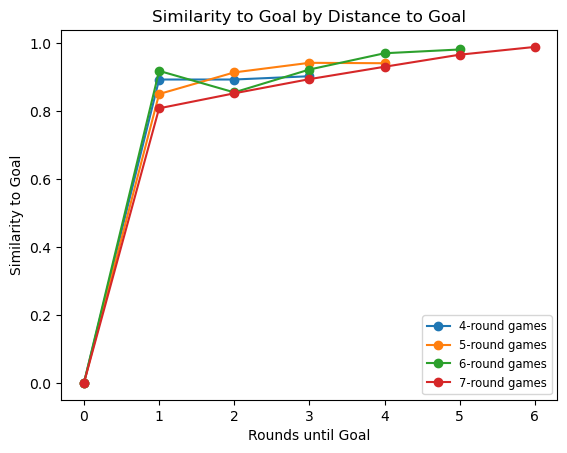

In [23]:
import spacy

nlp = spacy.load('en_core_web_md')

def similarity_to_goal(embedding_path, goal):
    return [ 1 - nlp(embedded_page).similarity(nlp(goal)) for embedded_page in embedding_path]

embeddings = all_paths[all_paths['finished'] == 1].merge(right=game_pairs_for_LLM, on=['game_pair','goal'])[['game_pair', 'game_length', 'goal', 'path_decoded']]
embeddings['simm_to_goal'] = embeddings.apply(lambda row: similarity_to_goal(row['path_decoded'], row['goal']), axis=1)
embeddings = embeddings[['game_pair', 'simm_to_goal', 'game_length']]

# create similarity path for game of length n
def reverse_list(lst):
    return lst[::-1]

def similarity_path(embeddings, game_length):
    embeddings = embeddings[embeddings['game_length'] == game_length]
    embeddings['simm_to_goal'] = embeddings['simm_to_goal'].apply(reverse_list)
    return [np.mean(simms) for simms in zip(*embeddings['simm_to_goal'])]

# Display
fig, ax = plt.subplots()
for l in [4, 5, 6, 7]:
    simm_path_reverse = similarity_path(embeddings, l)
    ax.plot(range(len(simm_path_reverse)), simm_path_reverse, marker = 'o', label=str(l) + "-round games")
ax.set_xlabel('Rounds until Goal')
ax.set_ylabel('Similarity to Goal')
ax.set_title('Similarity to Goal by Distance to Goal')
ax.legend(fontsize='small')
plt.show()

We see that embedding distance to goal increases as players approach the goal, suggesting a path toward game completion that is reasonable for human semantic thinking. Whether or not ChatGPT can emulate this increase through its game paths is our chief research question. We will make our findings robust by quantifying differences not only under embeddings, but also Wikispeedia-derived human semantic mappings and TF-IDF Wikipedia page content vectorization.

### 3.2 How does ChatGPT's rounds-to-goal compare to human players?

/tmp/ipykernel_1474471/2644339769.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(length_means.index, rotation=90)


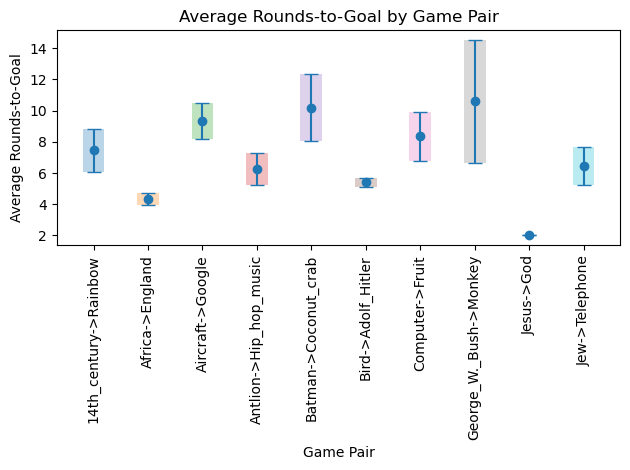

In [83]:
# average lengths and calculate CIs
lengths = all_paths[all_paths['finished'] == 1].merge(right=game_pairs_for_LLM, on='game_pair')[['game_pair', 'game_length', 'human_attempts']]
length_means = lengths.groupby('game_pair')['game_length'].agg(['mean', 'sem'])
length_means['lower'] = length_means['mean'] - 1.96 * length_means['sem']
length_means['upper'] = length_means['mean'] + 1.96 * length_means['sem']

# display
fig, ax = plt.subplots()
ax.errorbar(length_means.index, length_means['mean'], yerr=1.96 * length_means['sem'], fmt='o', capsize=5, label='Mean')
for i, pair in enumerate(length_means.index):
    ax.fill_between([i - 0.2, i + 0.2], length_means.loc[pair, 'lower'], length_means.loc[pair, 'upper'], alpha=0.3)
ax.set_xlabel('Game Pair')
ax.set_ylabel('Average Rounds-to-Goal')
ax.set_title('Average Rounds-to-Goal by Game Pair')
ax.set_xticklabels(length_means.index, rotation=90)
plt.tight_layout()

We recognize that the confidence interval on certain averages is wide. Thus, for each pair, we can also visualize the share of games completed over time (see below). This distribution-based view could provide deeper insight into differences between human and LLM game paths even at our current scale of observation counts.

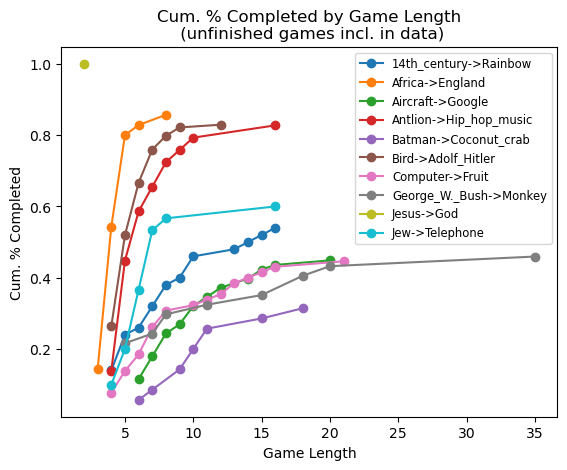

In [84]:
# cumsum completed by length,
lengths = all_paths[all_paths['finished'] == 1].merge(right=game_pairs_for_LLM, on='game_pair')[['game_pair', 'game_length', 'human_attempts']]
lengths = lengths.groupby('game_pair')['game_length'].value_counts().reset_index().merge(right=lengths.groupby('game_pair')['human_attempts'].agg('first').reset_index(), on='game_pair').copy()
lengths = lengths.sort_values(by=['game_pair', 'game_length'])
lengths['cum_completed'] = lengths.groupby('game_pair')['count'].agg('cumsum')
lengths['cum_completed_pct'] = lengths['cum_completed'] / lengths['human_attempts']
    
# display,
fig, ax = plt.subplots()
for key, grp in lengths.groupby('game_pair'):
    ax.plot(grp['game_length'], grp['cum_completed_pct'], marker = 'o', label=key)
ax.set_xlabel('Game Length')
ax.set_ylabel('Cum. % Completed')
ax.set_title('Cum. % Completed by Game Length\n (unfinished games incl. in data)')
ax.legend(fontsize='small')
plt.show()

### 3.3 Does ChatGPT employ the same 'zoom-out' to hub, 'zoom-in' to spoke Wikispeedia strategy as humans?

We intend to average for games of equal length the amount of outgoing page links at every round. This will be done for humans and ChatGPT separately. We can then match these 'page degree' curves by game length and quantify the significance of any differences.

Below, we present the average page degree over time in humans' 3-, 4-, 5-, and 6-round games for our selected game pairs.

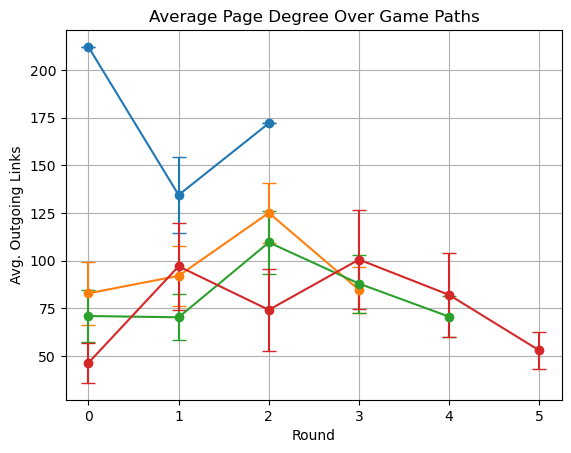

In [85]:
# Calculate degrees over time for page paths
paths = all_paths[all_paths['finished'] == 1].merge(right=game_pairs_for_LLM, on='game_pair')[['game_pair', 'game_length', 'path_decoded']]
paths['degree_path'] = [calculate_degrees(game_path) for game_path in paths['path_decoded']]

# Average results across game pairs for games of equal length
mea_at_stage = {}
moe_at_stage = {}

for game_length in [3, 4, 5, 6]:
    mea_at_stage[game_length] = {}
    moe_at_stage[game_length] = {}
    for i, row in paths.iterrows():
        if len(row['degree_path']) == game_length:
            for j in range(len(row['degree_path'])):
                if j not in mea_at_stage[game_length].keys():
                    mea_at_stage[game_length][j] = []
                mea_at_stage[game_length][j].append(row['degree_path'][j])
    for key in mea_at_stage[game_length].keys():
        moe_at_stage[game_length][key] = 1.96 * (np.nanstd(mea_at_stage[game_length][key], ddof=1) / np.sqrt(len(mea_at_stage[game_length][key])))
        mea_at_stage[game_length][key] = (np.nanmean(mea_at_stage[game_length][key]))

# Display   
for game_length in [3, 4, 5, 6]:
    mean_list = list(mea_at_stage[game_length].values())
    mofe_list = list(moe_at_stage[game_length].values())
    plt.errorbar(range(len(mean_list)), mean_list, yerr=mofe_list, fmt='-o', capsize=5)
 
plt.xlabel('Round')
plt.ylabel('Avg. Outgoing Links')
plt.title('Average Page Degree Over Game Paths')
plt.grid(True)
plt.show()

A 'zoom-out zoom-in' strategy would correspond to a curve with just one local exreme - a global maximum - occurring after the initial page. For our selected prompts, this is only observed in human data for 4-round games. A less restrictive test for the 'zoom-out zoom-in' strategy would fit each curve's data to a quadratic function and test whether the coefficient on the quadratic term is negative: 

In [86]:
def concave_quadratic_fit(means: list) -> bool:
    """Concave quadratic fit
    
    Args:
        means (list): list of means
    Returns:
        bool: whether quadratic fit is concave
    """
    is_concave = np.polyfit(np.arange(len(means)), means, 2)[0] < 0
    return is_concave

for game_degree in [3, 4, 5, 6]:
    print(str(game_degree) + "-round games exhibit a roughly concave degree path: " + str(concave_quadratic_fit(list(mea_at_stage[game_degree].values()))))

3-round games exhibit a roughly concave degree path: False
4-round games exhibit a roughly concave degree path: True
5-round games exhibit a roughly concave degree path: True
6-round games exhibit a roughly concave degree path: True


We can develop further metrics for capturing the 'zoom-out zoom-in' strategy by refining our degree metric (eg *lucrative* degree, which only factors in links which decrease short-path to target) and investigating the overlap between ChatGPT's specific intra-game Wikipedia pages and **global** human intra-game Wikipedia pages for a given goal category. The data for these further metrics can be developed from *shortest-path-distance-matrix.txt* in combination with *links.tsv*. 

### 3.4 How often does ChatGPT 'backtrack' compared to humans?

Similarly to 3.2, we intend to calculate each game pair's proportion of games with backtracking for humans and ChatGPT separately, yielding 20 proportions. We can then match these proportions by game pair and quantify the significance of any differences. Below we visualize the 10 human proportions (with 95% confidence intervals):

/tmp/ipykernel_1474471/1707042121.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(backtracks_proportions.index, rotation=90)


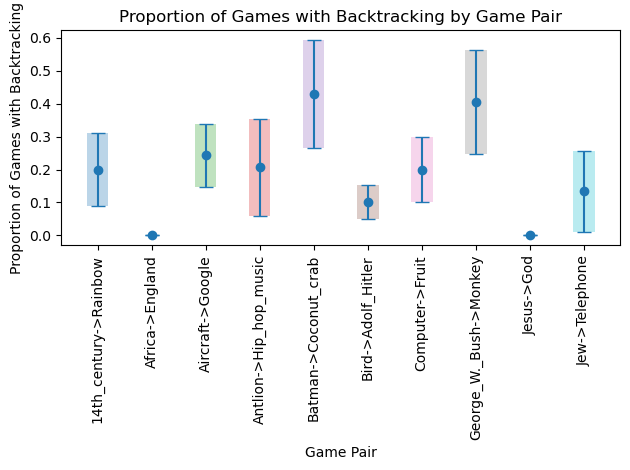

In [87]:
def proportion_ci(binary):
    conf_lev = 0.95
    return norm.ppf((1 + conf_lev) / 2) * np.sqrt((np.mean(binary) * (1 - np.mean(binary))) / len(binary))

# Proportions + confidence intervals
backtracks = all_paths.merge(right=game_pairs_for_LLM, on='game_pair')[['game_pair', 'game_length', 'backtrack_occurred']]
backtracks_proportions = backtracks.groupby('game_pair')['backtrack_occurred'].agg('mean').reset_index()
backtracks_proportions['moe'] = backtracks.groupby('game_pair')['backtrack_occurred'].apply(proportion_ci).reset_index()['backtrack_occurred']
backtracks_proportions['lower'] = backtracks_proportions['backtrack_occurred'] - backtracks_proportions['moe']
backtracks_proportions['upper'] = backtracks_proportions['backtrack_occurred'] + backtracks_proportions['moe']
backtracks_proportions.set_index('game_pair', inplace=True)
backtracks_proportions = backtracks_proportions.rename(columns={'backtrack_occurred':'proportion'})

# Display
fig, ax = plt.subplots()
ax.errorbar(backtracks_proportions.index, backtracks_proportions['proportion'], yerr=backtracks_proportions['moe'], fmt='o', capsize=5, label='Mean')
for i, pair in enumerate(backtracks_proportions.index):
    ax.fill_between([i - 0.2, i + 0.2], backtracks_proportions.loc[pair, 'lower'], backtracks_proportions.loc[pair, 'upper'], alpha=0.3)
ax.set_xlabel('Game Pair')
ax.set_ylabel('Proportion of Games with Backtracking')
ax.set_title('Proportion of Games with Backtracking by Game Pair')

ax.set_xticklabels(backtracks_proportions.index, rotation=90)
plt.tight_layout()

Once again, we find that the level of uncertainty around our sample statistic - in this case proportion of games with backtracking - may hinder quantitative comparison. Accordingly, we prepare below a view the intra-game location of backtracks by game pair, which may reveal differences in the timing of backtracking behavior by humans and ChatGPT.

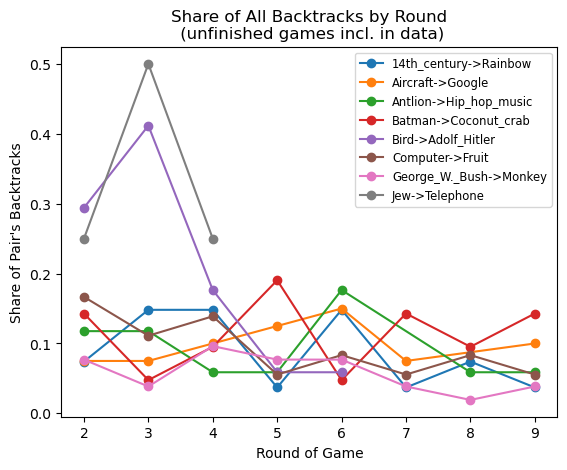

In [88]:
# Locate all backtrack locations across a pair's game paths (allow duplicate locations)
def find_backtracks(game_path):
    return [i for i, val in enumerate(game_path) if val == "<"]
def aggregate_backtrack_locations(backtracks_across_pair):
    return sum(backtracks_across_pair, [])

paths = all_paths.merge(right=game_pairs_for_LLM, on='game_pair')[['game_pair', 'game_length', 'path_decoded']]
paths['backtrack_moments'] = paths['path_decoded'].apply(lambda x: find_backtracks(x))
paths = paths.groupby('game_pair')['backtrack_moments'].agg(aggregate_backtrack_locations).reset_index()
paths = paths.explode('backtrack_moments')
paths = paths.groupby(['game_pair', 'backtrack_moments']).size().reset_index(name='count')
paths = paths.sort_values(['game_pair', 'backtrack_moments'])
paths = paths.merge(right=paths.groupby('game_pair')['count'].sum().reset_index(name='count_sum'), on='game_pair')
paths['backtrack_share'] = paths['count'] / paths['count_sum']
paths = paths[['game_pair', 'backtrack_moments','backtrack_share']]
paths = paths.query('backtrack_moments < 10')

# display
fig, ax = plt.subplots()
for key, grp in paths.groupby('game_pair'):
    ax.plot(grp['backtrack_moments'], grp['backtrack_share'], marker = 'o', label=key)
ax.set_xlabel('Round of Game')
ax.set_ylabel("Share of Pair's Backtracks")
ax.set_title("Share of All Backtracks by Round\n (unfinished games incl. in data)")
ax.legend(fontsize='small')
plt.show()


Apart from games with few rounds, which exhibit a single maximum occurring in their second round, the distribution of backclick timing appears to be relatively uniform. Whether or not ChatGPT exhibits this same relationship between backclicks and average length of game is therefore another question we intend to answer upon developing our ChatGPT game paths.

## 4. Supplementary Material


In this supplementary material, we retain our initial data exploration on the following datasets:

- links.tsv
- categories.tsv
- paths_finished.tsv
- paths_unfinished.tsv

We retain this analysis as it may become more relevant to our project as we gather ChatGPT game paths and conceive of further analyses.

### 4.1: Links

In [89]:
# The list of all links between articles
link = pd.read_csv(os.path.join(data_dir, 'links.tsv'), sep='\t', skiprows=12, header = None, names = ['linkSource','linkTarget'])
# Article names are URL-encoded, so it needs to be decoded
link[['linkSource', 'linkTarget']] = link[['linkSource', 'linkTarget']].applymap(unquote)
link[:10]

/tmp/ipykernel_1474471/2165927072.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  link[['linkSource', 'linkTarget']] = link[['linkSource', 'linkTarget']].applymap(unquote)


,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland
5,Áedán_mac_Gabráin,Isle_of_Man
6,Áedán_mac_Gabráin,Monarchy
7,Áedán_mac_Gabráin,Orkney
8,Áedán_mac_Gabráin,Picts
9,Áedán_mac_Gabráin,Scotland


**Which source article has the most outgoing links?**

In [90]:
source_frequency = link['linkSource'].value_counts()
source_frequency[:10]

linkSource
United_States                                294
Driving_on_the_left_or_right                 255
List_of_countries                            244
List_of_circulating_currencies               236
List_of_sovereign_states                     216
Africa                                       212
List_of_countries_by_system_of_government    207
Lebanon                                      192
Interpol                                     191
Armenia                                      186
Name: count, dtype: int64

**Which target article has the most incoming links?**

In [91]:
target_frequency = link['linkTarget'].value_counts()
target_frequency[:10]

linkTarget
United_States       1551
United_Kingdom       972
France               959
Europe               933
England              751
World_War_II         751
Germany              743
India                611
English_language     598
London               587
Name: count, dtype: int64

**Which articles are more popular?**

In [92]:
hot_articles = pd.concat([source_frequency, target_frequency], axis=1, sort=False)
hot_articles.columns = ['source_count', 'target_count']
hot_articles = hot_articles.fillna(0) 
hot_articles['total_count'] = hot_articles['source_count'] + hot_articles['target_count']
hot_articles[:10]

,source_count,target_count,total_count
United_States,294.0,1551.0,1845.0
Driving_on_the_left_or_right,255.0,0.0,255.0
List_of_countries,244.0,63.0,307.0
List_of_circulating_currencies,236.0,8.0,244.0
List_of_sovereign_states,216.0,43.0,259.0
Africa,212.0,477.0,689.0
List_of_countries_by_system_of_government,207.0,246.0,453.0
Lebanon,192.0,114.0,306.0
Interpol,191.0,13.0,204.0
Armenia,186.0,99.0,285.0


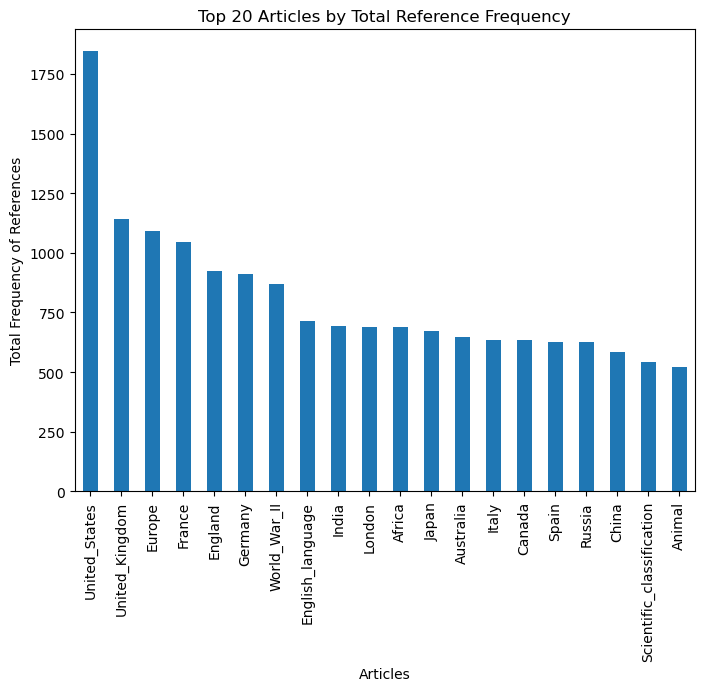

In [29]:
top_articles = hot_articles.sort_values(by='total_count', ascending=False).head(20)

plt.figure(figsize=(8, 6))
top_articles['total_count'].plot(kind='bar')
plt.title('Top 20 Articles by Total Reference Frequency')
plt.xlabel('Articles')
plt.ylabel('Total Frequency of References')
plt.xticks(rotation=90) 
plt.show()

### 4.2: Categories

In [93]:
# Hierarchical categories of all articles
categories = pd.read_csv(os.path.join(data_dir, 'categories.tsv'), sep='\t', skiprows=13, header = None, names = ['article','category'])
categories[['article', 'category']] = categories[['article', 'category']].applymap(unquote)
categories[:10]

/tmp/ipykernel_1474471/3432278097.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  categories[['article', 'category']] = categories[['article', 'category']].applymap(unquote)


,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists
5,Éire,subject.Countries
6,Éire,subject.Geography.European_Geography.European_...
7,Óengus_I_of_the_Picts,subject.History.British_History.British_Histor...
8,Óengus_I_of_the_Picts,subject.People.Historical_figures
9,€2_commemorative_coins,subject.Business_Studies.Currency


**What's the most frequent categories?**

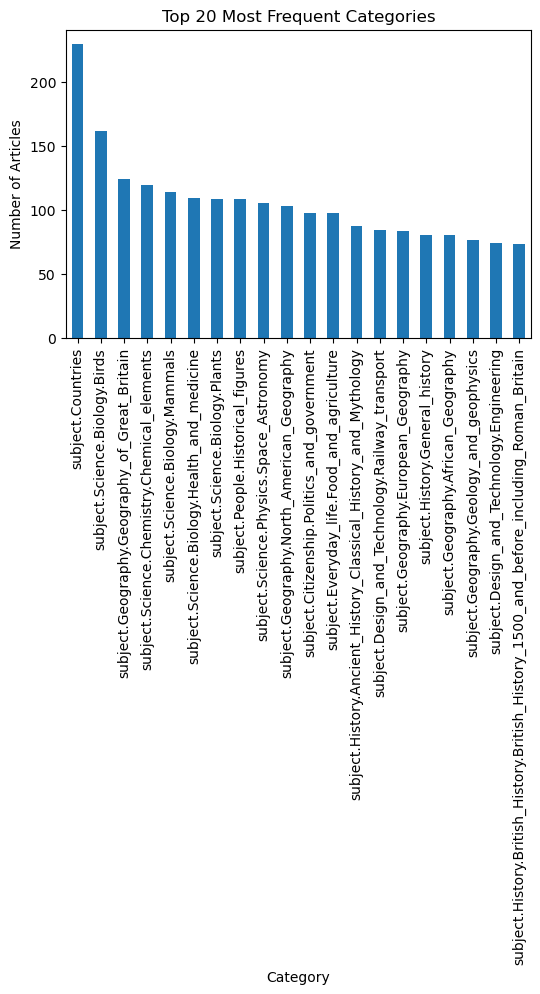

In [31]:
category_counts = categories['category'].value_counts()
top_categories = category_counts.head(20)

plt.figure(figsize=(6, 4))
top_categories.plot(kind='bar')
plt.title('Top 20 Most Frequent Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)  
plt.show()

**What's the most frequent MAIN categories?**

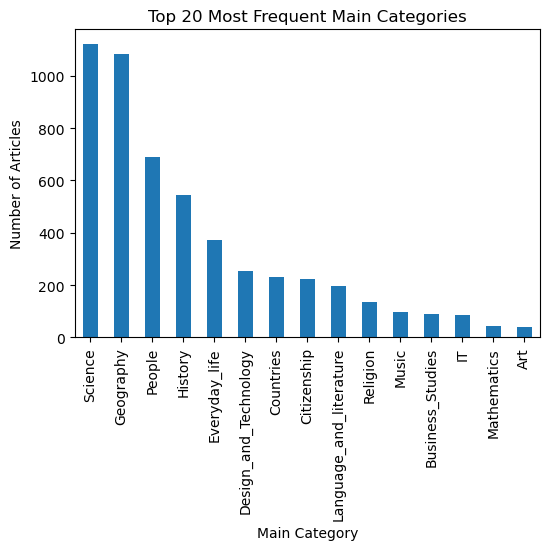

In [94]:
# Split each category string, skip the first word ("subject"), and take the second word as the main category.
categories['main_category'] = categories['category'].apply(lambda x: x.split('.')[1] if len(x.split('.')) > 1 else x)

# Calculate the number of articles for each main category.
main_category_counts = categories['main_category'].value_counts()
top_main_categories = main_category_counts.head(20)

plt.figure(figsize=(6, 4))
top_main_categories.plot(kind='bar')
plt.title('Top 20 Most Frequent Main Categories')
plt.xlabel('Main Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)  
plt.show()

### 4.3: Paths

In [95]:
paths_finished = pd.read_csv(os.path.join(data_dir, 'paths_finished.tsv'), sep='\t', skiprows = 16, header = None, names = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
paths_unfinished = pd.read_csv(os.path.join(data_dir, 'paths_unfinished.tsv'), sep='\t', skiprows=17, header = None, names = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])

print('Completed paths: ' + str(len(paths_finished)))
print('Abandoned due to restart: ' + str(len(paths_unfinished[paths_unfinished['type'] == 'restart'])))
print('Abandoned due to timeout: ' + str(len(paths_unfinished[paths_unfinished['type'] == 'timeout'])))

Completed paths: 51318
Abandoned due to restart: 15552
Abandoned due to timeout: 9323


In [96]:
# Game finished rate
finished = 15552
unfinished = 9323 + 51318

game_finished_rate = finished / (finished + unfinished) * 100
game_finished_rate_percentage = "{:.2f}%".format(game_finished_rate)
print(game_finished_rate_percentage)

20.41%


### 4.4: Paths Finished

In [97]:
paths_finished[:10]

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
5,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN
6,36dabfa133b20e3c,1249525912,112,14th_century;China;Gunpowder;Fire,2.0
7,20418ff4797f96be,1229188046,139,14th_century;Time;Isaac_Newton;Light;Color;Rai...,1.0
8,08888b1b428dd90e,1232241510,74,14th_century;Time;Light;Rainbow,3.0
9,08888b1b428dd90e,1232241601,167,14th_century;15th_century;Plato;Nature;Ultravi...,NaN


In [98]:
split_data = paths_finished['path'].str.split(';')

def decode_list(url_encoded_list: list) -> list:
    """Decodes url_encoded path.
    
    Args:
        url_encoded_list (list): url_encoded path
    Returns:
        list: decoded path
    """
    return [urllib.parse.unquote(element).replace(',', '') for element in url_encoded_list]

split_data = split_data.apply(decode_list)

In [99]:
# extract source, target, and middle part of an article
paths_finished['source'] = split_data.apply(lambda x: x[0])
paths_finished['target'] = split_data.apply(lambda x: x[-1])
paths_finished['middle'] = split_data.apply(lambda x: x[1:-1])
flattened_middle = [item for sublist in paths_finished['middle'] for item in sublist]

In [100]:
# most common articles in the middle along a path (excluding source and target)
Counter(flattened_middle).most_common(10)

[('<', 20561),
 ('United_States', 8824),
 ('Europe', 4319),
 ('United_Kingdom', 3860),
 ('Earth', 3153),
 ('England', 3123),
 ('Africa', 2693),
 ('World_War_II', 2225),
 ('North_America', 1804),
 ('Germany', 1676)]

In [39]:
# most popular source
paths_finished['source'].value_counts().head(10)

source
Brain       1092
Asteroid    1059
Theatre      931
Pyramid      674
Batman       602
Bird         275
Cat          226
Dog          175
Jesus        145
Beer         135
Name: count, dtype: int64

In [101]:
# most popular target
paths_finished['target'].value_counts().head(10)

target
Telephone            1134
Viking               1071
Zebra                 955
Bean                  673
Adolf_Hitler          603
Sun                   218
God                   200
Jesus                 197
Wood                  185
Great_white_shark     184
Name: count, dtype: int64

In [41]:
# most popular source-target combination (i.e. most popular game)
paths_finished['source_target'] = paths_finished['source'] + '_' + paths_finished['target']
paths_finished['source_target'].value_counts().head(20)

source_target
Asteroid_Viking              1043
Brain_Telephone              1040
Theatre_Zebra                 905
Pyramid_Bean                  642
Batman_Wood                   148
Bird_Great_white_shark        138
Batman_The_Holocaust          119
Bird_Adolf_Hitler             107
Beer_Sun                       99
Batman_Banana                  69
Cat_Computer                   57
Cat_Microsoft                  56
Dog_Telephone                  53
Flower_Adolf_Hitler            51
Automobile_Pluto               47
Dog_Venus                      47
Batman_Bible                   43
Aluminium_chloride_Parrot      42
England_God                    42
Achilles_tendon_Ocean          40
Name: count, dtype: int64

In [102]:
# How many steps do one game take?
paths_finished['path_steps'] = split_data.apply(lambda x: len(x) - 1)
paths_finished.drop('rating', axis=1, inplace=True)
paths_finished.path_steps.unique()

array([  8,   4,   7,   3,   6,   5,  12,   9,  15,  14,  13,  26,  16,
        21,   2,  10,  17,  18,  20,  11,   1,  23,  19,  34,  29,  65,
        35,  64,  33,  25,  40,  22,  30,  70,  28,  85,  31,  52,  27,
        24,  37,  48,  39,  45,   0,  71, 103,  41,  49,  32,  51,  57,
        53, 434,  61,  36,  69,  62,  47,  84,  46,  38,  56,  76,  50,
        44,  54,  55,  42, 118,  95,  43,  59,  98,  66,  79,  86,  60,
        68])

In [43]:
paths_finished[:10]

,hashedIpAddress,timestamp,durationInSec,path,source,target,middle,source_target,path_steps
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,14th_century,African_slave_trade,"[15th_century, 16th_century, Pacific_Ocean, At...",14th_century_African_slave_trade,8
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,14th_century,African_slave_trade,"[Europe, Africa, Atlantic_slave_trade]",14th_century_African_slave_trade,4
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,14th_century,African_slave_trade,"[Niger, Nigeria, British_Empire, Slavery, Afri...",14th_century_African_slave_trade,7
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,14th_century,Greece,"[Renaissance, Ancient_Greece]",14th_century_Greece,3
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,14th_century,John_F._Kennedy,"[Italy, Roman_Catholic_Church, HIV, Ronald_Rea...",14th_century_John_F._Kennedy,6
5,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,14th_century,John_F._Kennedy,"[Europe, North_America, United_States, Preside...",14th_century_John_F._Kennedy,5
6,36dabfa133b20e3c,1249525912,112,14th_century;China;Gunpowder;Fire,14th_century,Fire,"[China, Gunpowder]",14th_century_Fire,3
7,20418ff4797f96be,1229188046,139,14th_century;Time;Isaac_Newton;Light;Color;Rai...,14th_century,Rainbow,"[Time, Isaac_Newton, Light, Color]",14th_century_Rainbow,5
8,08888b1b428dd90e,1232241510,74,14th_century;Time;Light;Rainbow,14th_century,Rainbow,"[Time, Light]",14th_century_Rainbow,3
9,08888b1b428dd90e,1232241601,167,14th_century;15th_century;Plato;Nature;Ultravi...,14th_century,Rainbow,"[15th_century, Plato, Nature, Ultraviolet, Color]",14th_century_Rainbow,6


### 4.5: Unfinished Paths

In [103]:
paths_unfinished.drop('type', axis=1, inplace=True)

split_data_2 = paths_unfinished['path'].str.split(';')
split_data_2 = split_data_2.apply(decode_list)

paths_unfinished['source'] = split_data_2.apply(lambda x: x[0])
paths_unfinished['middle'] = split_data_2.apply(lambda x: x[1:])
flattened_middle_2 = [item for sublist in paths_unfinished['middle'] for item in sublist]

In [104]:
# most common articles in the middle (excluding source and target)
Counter(flattened_middle_2).most_common(10)

[('<', 12907),
 ('United_States', 3546),
 ('United_Kingdom', 1418),
 ('Europe', 1234),
 ('England', 1181),
 ('Earth', 981),
 ('Africa', 771),
 ('Human', 754),
 ('Animal', 737),
 ('Mammal', 708)]

In [107]:
# most common source article for unfinished paths
paths_unfinished['path_steps'] = split_data_2.apply(lambda x: len(x) - 1)
paths_unfinished['source_target'] = paths_unfinished['source'] + '_' + paths_unfinished['target']
paths_unfinished.source.value_counts().head(10)

source
Brain       1021
Pyramid      953
Theatre      892
Asteroid     745
Batman       345
Cat          143
Dog          105
Computer      94
Bird          71
Beer          62
Name: count, dtype: int64

In [105]:
# most common target article for unfinished paths
paths_unfinished.target.value_counts().head(10)

target
Telephone                 1060
Bean                       950
Zebra                      893
Viking                     734
Tiger_Woods                218
Nurse_sharks               124
Three_Laws_of_Robotics     102
Economy_of_India            94
Adolf_Hitler                94
Wood                        93
Name: count, dtype: int64

In [48]:
# most popular game for unifinished paths
paths_unfinished.source_target.value_counts().head(10)

source_target
Brain_Telephone    1004
Pyramid_Bean        944
Theatre_Zebra       872
Asteroid_Viking     727
Batman_Wood          75
Batman_Banana        56
Cat_Computer         43
Aircraft_Google      43
Beer_Sun             43
Cat_Microsoft        42
Name: count, dtype: int64

In [108]:
new_order = ['hashedIpAddress','timestamp','durationInSec','path','source','target','middle','path_steps','source_target']
paths_unfinished = paths_unfinished[new_order]
paths_unfinished[:10]

,hashedIpAddress,timestamp,durationInSec,path,source,target,middle,path_steps,source_target
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Obi-Wan_Kenobi,Microsoft,[],0,Obi-Wan_Kenobi_Microsoft
1,26141fd878806294,1297055651,1805,Julius_Caesar,Julius_Caesar,Caracas,[],0,Julius_Caesar_Caracas
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,Malawi,First_Crusade,"[Democracy, Alexander_the_Great]",2,Malawi_First_Crusade
3,53a53bc244e08a6a,1297094761,49,Paraguay,Paraguay,Mount_St._Helens,[],0,Paraguay_Mount_St._Helens
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Paraguay,Mount_St._Helens,[Bolivia],1,Paraguay_Mount_St._Helens
5,131600803df4895e,1297100557,2009,Agriculture;History_of_the_world;China;Yangtze...,Agriculture,Grand_Canal_of_China,"[History_of_the_world, China, Yangtze_River]",3,Agriculture_Grand_Canal_of_China
6,486bb79910fe9dd2,1297101660,1932,Mind;Christianity;Europe;Renaissance;Ancient_G...,Mind,Scouting,"[Christianity, Europe, Renaissance, Ancient_Gr...",6,Mind_Scouting
7,6d136e371e42474f,1297102070,175,4-2-0;United_States;Agriculture;Sugar;Australia,4-2-0,Cane_Toad,"[United_States, Agriculture, Sugar, Australia]",4,4-2-0_Cane_Toad
8,6d136e371e42474f,1297102100,19,Logic,Logic,Moon_landing,[],0,Logic_Moon_landing
9,6d136e371e42474f,1297104110,2006,Logic;Computer_science;Science;Physical_scienc...,Logic,Moon_landing,"[Computer_science, Science, Physical_science, ...",8,Logic_Moon_landing


### 4.6: Paths with Categories

In [ ]:
paths_finished['finished'] = 1
paths_unfinished['finished'] = 0
# combine finished paths and unfinished paths
paths_all = pd.concat([paths_finished, paths_unfinished], ignore_index=True) 

In [ ]:
# most popular game for combined data
paths_all['source_target'].value_counts().head(10)

source_target
Brain_Telephone           2044
Theatre_Zebra             1777
Asteroid_Viking           1770
Pyramid_Bean              1586
Batman_Wood                223
Bird_Great_white_shark     168
Batman_The_Holocaust       149
Beer_Sun                   142
Bird_Adolf_Hitler          129
Batman_Banana              125
Name: count, dtype: int64

In [ ]:
# Some articles belong to more than one category
category_counts = categories.groupby('article')['category'].count()
articles_with_multiple_categories = category_counts[category_counts > 1]
print(articles_with_multiple_categories)

article
Abacus                   2
Abbey                    2
Abbot                    2
Abkhazia                 2
Abu_Dhabi                2
                        ..
Zuid-Gelders             2
Áedán_mac_Gabráin        2
Åland                    2
Éire                     2
Óengus_I_of_the_Picts    2
Name: category, Length: 598, dtype: int64


In [ ]:
# For example...
categories[categories.article == 'Greece']

,article,category,main_category
2026,Greece,subject.Countries,Countries
2027,Greece,subject.Geography.European_Geography.European_...,Geography


In [ ]:
# Keep only the first category per article
first_category_per_article = categories.groupby('article').first()
first_category_per_article.head(10)

,category,main_category
article,,
10th_century,subject.History.General_history,History
11th_century,subject.History.General_history,History
12th_century,subject.History.General_history,History
13th_century,subject.History.General_history,History
14th_century,subject.History.General_history,History
15th_Marine_Expeditionary_Unit,subject.History.Military_History_and_War,History
15th_century,subject.History.General_history,History
16_Cygni,subject.Science.Physics.Space_Astronomy,Science
16_Cygni_Bb,subject.Science.Physics.Space_Astronomy,Science


In [ ]:
# merge paths with category
paths_all_category = paths_all.merge(first_category_per_article, how='left', left_on='target', right_on='article')
paths_all_category[:10]

,hashedIpAddress,timestamp,durationInSec,path,source,target,middle,source_target,path_steps,finished,category,main_category
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,14th_century,African_slave_trade,"[15th_century, 16th_century, Pacific_Ocean, At...",14th_century_African_slave_trade,8,1,subject.History.General_history,History
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,14th_century,African_slave_trade,"[Europe, Africa, Atlantic_slave_trade]",14th_century_African_slave_trade,4,1,subject.History.General_history,History
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,14th_century,African_slave_trade,"[Niger, Nigeria, British_Empire, Slavery, Afri...",14th_century_African_slave_trade,7,1,subject.History.General_history,History
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,14th_century,Greece,"[Renaissance, Ancient_Greece]",14th_century_Greece,3,1,subject.Countries,Countries
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,14th_century,John_F._Kennedy,"[Italy, Roman_Catholic_Church, HIV, Ronald_Rea...",14th_century_John_F._Kennedy,6,1,subject.People.USA_Presidents,People
5,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,14th_century,John_F._Kennedy,"[Europe, North_America, United_States, Preside...",14th_century_John_F._Kennedy,5,1,subject.People.USA_Presidents,People
6,36dabfa133b20e3c,1249525912,112,14th_century;China;Gunpowder;Fire,14th_century,Fire,"[China, Gunpowder]",14th_century_Fire,3,1,subject.Science.Chemistry.General_Chemistry,Science
7,20418ff4797f96be,1229188046,139,14th_century;Time;Isaac_Newton;Light;Color;Rai...,14th_century,Rainbow,"[Time, Isaac_Newton, Light, Color]",14th_century_Rainbow,5,1,subject.Geography.Climate_and_the_Weather,Geography
8,08888b1b428dd90e,1232241510,74,14th_century;Time;Light;Rainbow,14th_century,Rainbow,"[Time, Light]",14th_century_Rainbow,3,1,subject.Geography.Climate_and_the_Weather,Geography
9,08888b1b428dd90e,1232241601,167,14th_century;15th_century;Plato;Nature;Ultravi...,14th_century,Rainbow,"[15th_century, Plato, Nature, Ultraviolet, Color]",14th_century_Rainbow,6,1,subject.Geography.Climate_and_the_Weather,Geography


In [ ]:
# What are the main categories?
print(paths_all_category.main_category.unique())

['History' 'Countries' 'People' 'Science' 'Geography' 'Art' 'Music'
 'Citizenship' 'Everyday_life' 'Design_and_Technology' 'IT'
 'Language_and_literature' 'Mathematics' 'Religion' nan 'Business_Studies']


In [ ]:
# Most popular games and their categories
play_counts = paths_all_category['source_target'].value_counts().reset_index()
play_counts.columns = ['source_target', 'play_count']
paths_all_count_category = play_counts.merge(paths_all_category[['source_target', 'category','main_category']].drop_duplicates(), on='source_target', how='left')
paths_all_count_category

,source_target,play_count,category,main_category
0,Brain_Telephone,2044,subject.Design_and_Technology.Engineering,Design_and_Technology
1,Theatre_Zebra,1777,subject.Science.Biology.Mammals,Science
2,Asteroid_Viking,1770,subject.History.British_History.British_Histor...,History
3,Pyramid_Bean,1586,subject.Everyday_life.Food_and_agriculture,Everyday_life
4,Batman_Wood,223,subject.Design_and_Technology.Engineering,Design_and_Technology
...,...,...,...,...
42707,Arctic_Monkeys_Nitrogen_fixation,1,subject.Science.Biology.General_Biology,Science
42708,Arctic_Monkeys_National_parks_of_England_and_W...,1,subject.Geography.Geography_of_Great_Britain,Geography
42709,Arctic_Monkeys_Mercia,1,subject.History.British_History.British_Histor...,History
42710,Arctic_Monkeys_Fascism,1,subject.Citizenship.Politics_and_government,Citizenship


In [ ]:
# Select sample popular games from different categories
sorted_df = paths_all_count_category.sort_values(by='play_count', ascending=False)

top_games = []

for _, row in sorted_df.iterrows():
    if len(top_games) >= 10: 
        break

    if not any(game['main_category'] == row['main_category'] for game in top_games):
        top_games.append({
            'source_target': row['source_target'],
            'category': row['category'],
             'main_category': row['main_category'],
            'play_count': row['play_count']
        })
        
top_games = pd.DataFrame(top_games)
top_games

,source_target,category,main_category,play_count
0,Brain_Telephone,subject.Design_and_Technology.Engineering,Design_and_Technology,2044
1,Theatre_Zebra,subject.Science.Biology.Mammals,Science,1777
2,Asteroid_Viking,subject.History.British_History.British_Histor...,History,1770
3,Pyramid_Bean,subject.Everyday_life.Food_and_agriculture,Everyday_life,1586
4,Bird_Adolf_Hitler,subject.People.Political_People,People,129
5,Cat_Computer,subject.IT.Computing_hardware_and_infrastructure,IT,100
6,Cat_Microsoft,subject.Business_Studies.Companies,Business_Studies,98
7,Batman_Bible,subject.Religion.Religious_texts,Religion,58
8,Achilles_tendon_Ocean,subject.Geography.Geology_and_geophysics,Geography,51
9,Computer_Russia,subject.Countries,Countries,35


In [ ]:
# The most popular games from different categories
game_1 = paths_all_category[paths_all_category.source_target == 'Brain_Telephone']['main_category'].unique()[0]
game_2 = paths_all_category[paths_all_category.source_target == 'Theatre_Zebra']['main_category'].unique()[0]
game_3 = paths_all_category[paths_all_category.source_target == 'Asteroid_Viking']['main_category'].unique()[0]
game_4 = paths_all_category[paths_all_category.source_target == 'Pyramid_Bean']['main_category'].unique()[0]
game_5 = paths_all_category[paths_all_category.source_target == 'Bird_Adolf_Hitler']['main_category'].unique()[0]
game_6 = paths_all_category[paths_all_category.source_target == 'Cat_Computer']['main_category'].unique()[0]
game_7 = paths_all_category[paths_all_category.source_target == 'Cat_Microsoft']['main_category'].unique()[0]
game_8 = paths_all_category[paths_all_category.source_target == 'Batman_Bible']['main_category'].unique()[0]
game_9 = paths_all_category[paths_all_category.source_target == 'Achilles_tendon_Ocean']['main_category'].unique()[0]
game_10 = paths_all_category[paths_all_category.source_target == 'Computer_Russia']['main_category'].unique()[0]

print(game_1)
print(game_2)
print(game_3)
print(game_4)
print(game_5)
print(game_6)
print(game_7)
print(game_8)
print(game_9)
print(game_10)

Design_and_Technology
Science
History
Everyday_life
People
IT
Business_Studies
Religion
Geography
Countries


In [ ]:
# Selected games dataframe
selected_games = ['Brain_Telephone','Theatre_Zebra','Asteroid_Viking','Pyramid_Bean','Bird_Adolf_Hitler','Cat_Computer',
                 'Cat_Microsoft','Batman_Bible','Achilles_tendon_Ocean','Computer_Russia']
paths_all_category_selected = paths_all_category[paths_all_category.source_target.isin(selected_games)]
paths_all_category_selected
selected_games_df = paths_all_category_selected.groupby('source_target').agg({'path_steps':'mean','finished':'mean','main_category':'first'}).reset_index()
selected_games_df

,source_target,path_steps,finished,main_category
0,Achilles_tendon_Ocean,4.921569,0.784314,Geography
1,Asteroid_Viking,5.421469,0.589266,History
2,Batman_Bible,4.086207,0.741379,Religion
3,Bird_Adolf_Hitler,3.976744,0.829457,People
4,Brain_Telephone,4.523483,0.508806,Design_and_Technology
5,Cat_Computer,4.740000,0.570000,IT
6,Cat_Microsoft,5.387755,0.571429,Business_Studies
7,Computer_Russia,3.800000,0.828571,Countries
8,Pyramid_Bean,5.530265,0.404792,Everyday_life
9,Theatre_Zebra,5.337648,0.509285,Science


/home/drudao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/drudao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/drudao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


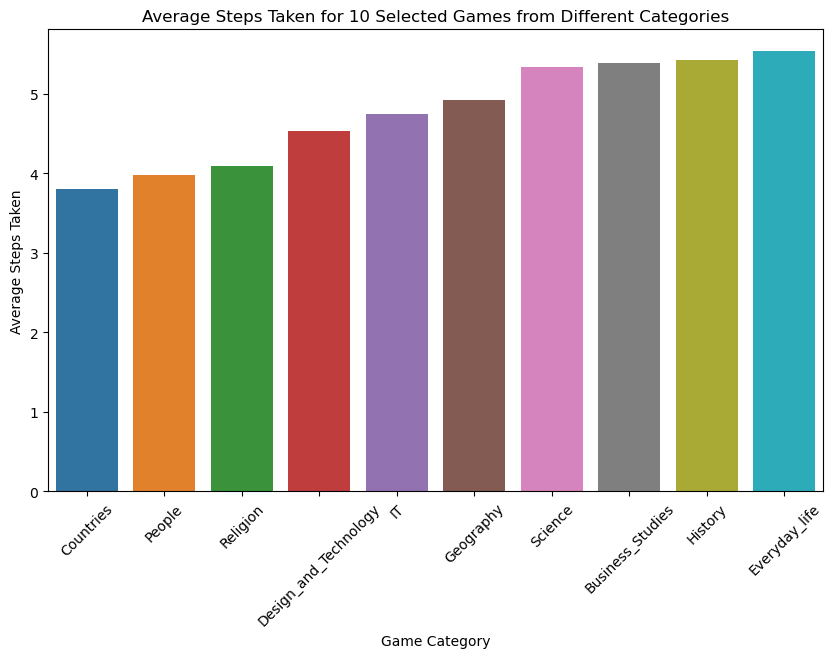

In [ ]:
# Average Steps Taken for 10 Selected Games from Different Categories
plt.figure(figsize=(10,6))
sns.barplot(x='main_category', y='path_steps', data=selected_games_df.sort_values('path_steps'))
plt.title('Average Steps Taken for 10 Selected Games from Different Categories')
plt.xlabel('Game Category')
plt.ylabel('Average Steps Taken')
plt.xticks(rotation=45)
plt.show()

/home/drudao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/drudao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/drudao/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


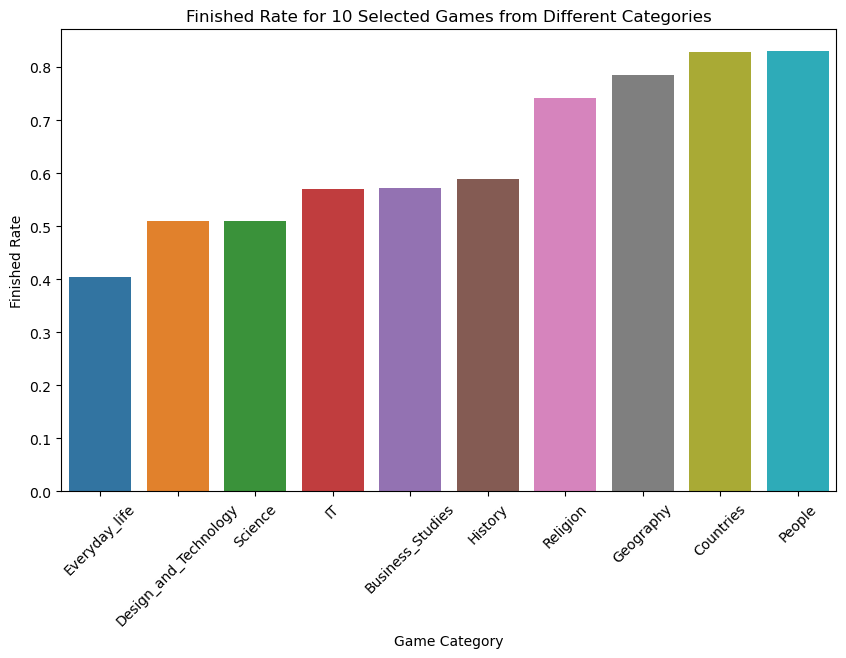

In [ ]:
# Finished Rate for 10 Selected Games from Different Categories
plt.figure(figsize=(10,6))
sns.barplot(x='main_category', y='finished', data=selected_games_df.sort_values('finished'))
plt.title('Finished Rate for 10 Selected Games from Different Categories')
plt.xlabel('Game Category')
plt.ylabel('Finished Rate')
plt.xticks(rotation=45)
plt.show()